# To-Do 
Words with highest/lowest CV IKI  
Bigrams with highest/lowest CV IKI  
Difference between avg. CV IKI by word type between individuals  



make extra figures into a separate document  
put stats under header for each type of analysis  
put MRS analysis in different document

In [1]:
import os
import numpy as np
import pandas as pd
import math
import glob
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import variation
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import pingouin as pg
import itertools as it
from great_tables import GT, html
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

import typingmod as typ

# Functions and Dataframe setup
___

In [2]:
# Setting save directory
save_dir = r'/Users/rubi/Desktop/Github/typingexp/typing_task_analysis/'\
           'figures/'

In [3]:
# Collects and aggregates all subject data

# Getting subject data folders from server
server = r'/Volumes/greenhouse/typingtask_data/subject_data'
os.chdir(server)

# Looping through selected subject folders, getting appropriate paths to data, 
# and making sID list (only includes subjects selected for manuscript 1)
sub_folders_turbo = list(pd.read_csv(r'/Users/rubi/Desktop/Github/typingexp/'\
                                     'typing_task_analysis/manuscript_IDs.csv')
                                     ['with_turbo'])
all_bytrial = pd.DataFrame()
all_bybigram = pd.DataFrame()
ID_list = []
for sub in sub_folders_turbo:
    sub_folder = r'/Volumes/greenhouse/typingtask_data/'\
                 'subject_data/%s/psychopy_data/edited' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    bytrial = pd.read_csv(glob.glob('*_bytrial.csv')[0])
    bybigram = pd.read_csv(glob.glob('*_bybigram.csv')[0])
    all_bytrial = pd.concat([all_bytrial, bytrial])
    all_bybigram = pd.concat([all_bybigram, bybigram])
    ID_list.append(sID)

# Makes list of folders for subjects without turbo typing data
server_noturbo = r'/Volumes/greenhouse/typingtask_data/subject_data/'\
                 'not_used/no_turbotyping/'
os.chdir(server_noturbo)
sub_folders_noturbo = list(pd.read_csv(r'/Users/rubi/Desktop/Github/typingexp/'\
                                     'typing_task_analysis/manuscript_IDs.csv')
                                     ['without_turbo'].dropna())

# Gets data from subjects without turbo typing
for sub in sub_folders_noturbo:
    sub_folder = server_noturbo + r'%s/psychopy_data/edited' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    bytrial = pd.read_csv(glob.glob('*_bytrial.csv')[0])
    bybigram = pd.read_csv(glob.glob('*_bybigram.csv')[0])
    all_bytrial = pd.concat([all_bytrial, bytrial])
    all_bybigram = pd.concat([all_bybigram, bybigram])
    ID_list.append(sID)

In [4]:
# Creates a trial-based dataframe with data from all subjects

# Concatenating all trial-based dataframes
all_trials = all_bytrial.reset_index(drop=True)
all_trials.drop(columns = ['Unnamed: 0'], inplace = True)
all_trials = all_trials.sort_values(by=['sID', 
                                        'trial_num', 
                                        'rep_num']).reset_index(drop = True)

# Adding IKI columns
all_rts = typ.rt_columns(all_trials)
all_trials = pd.concat([all_trials, typ.iki(all_rts).drop(columns=['string'])], 
                       axis = 1)

# Changing column names to identify they are IKI values
change = {}
for col in all_trials.columns:
    if isinstance(col, int):
        change[col] = 'iki_' + str(int(col)+1)
all_trials = all_trials.rename(columns=change)

# Changing column name of 'key_resp.rt.1' to identify it as reaction time
all_trials = all_trials.rename(columns={'key_resp.rt.1': 'RT'})

# Removing all trials that include an IKI larger than 1 second
iki_columns = all_trials[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
trial_exclude = iki_columns[iki_columns.apply(lambda row: (row > 1).any(), axis=1)]
trial_exlcude_index = trial_exclude.index
all_trials = all_trials.drop(trial_exlcude_index)

12


In [5]:
# Creates a bigram-based dataframe with data from all subjects

# Concatenating all bigram-based dataframes
all_bigrams = all_bybigram.reset_index(drop=True)
all_bigrams = all_bigrams.sort_values(by=['sID'])
all_bigrams.drop(columns = ['Unnamed: 0'], inplace = True)
all_bigrams = all_bigrams.sort_values(by=['sID', 
                                          'trial_num', 
                                          'rep_num', 
                                          'bigram_loc'])

# Removing all bigrams from trials that include an IKI larger than 1 second
bg_exclude = all_bigrams[all_bigrams['IKI'] > 1]
bg_exlcude_index = bg_exclude.index
all_bigrams = all_bigrams.drop(bg_exlcude_index)

# Saving all_bigrams to .csv
all_bigrams.to_csv(save_dir + '/all_bigrams.csv')

In [6]:
# Sorting ID list by ascending value
ID_list.sort()

# Checking how many participants
len(ID_list)

37

In [7]:
# Gets rid of runtime error about invalid division
# np.seterr(invalid='ignore')

In [8]:
# Making filtered dataframes by errors
corr_trials = all_trials[all_trials['trial_corr'] == True]
incorr_trials = all_trials[all_trials['trial_corr'] == False]

corr_trials_bybg = all_bigrams[all_bigrams['trial_corr'] == True]
incorr_trials_bybg = all_bigrams[all_bigrams['trial_corr'] == False]

# Excludes only incorrect bigrams 
corr_bgs = all_bigrams[all_bigrams['bg_corr'] == True]
incorr_bgs = all_bigrams[all_bigrams['bg_corr'] == False]

corr_rts = typ.rt_columns(corr_trials)
incorr_rts = typ.rt_columns(incorr_trials)

# Making dataframe with only correct trials that have ikis 
# within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.columns:
        if col.startswith('iki_'):
            avg_iki = sub_df[col].mean()
            sd_iki = sub_df[col].std()
            sub_df = sub_df[(sub_df[col] < (avg_iki + 2*sd_iki)) 
                     & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])

# Making dataframe with only correct bigrams that have ikis 
# within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials_bybg[corr_trials_bybg.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) 
             & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])
    
# Making dataframe with both correct and incorrect bigrams 
# that have ikis within 2sd
all_tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = all_bigrams[all_bigrams.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) 
             & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    all_tight_bgs = pd.concat([all_tight_bgs, sub_df])

# Saving corr_trials_bybg to .csv
corr_trials_bybg.to_csv(save_dir + '/corr_trials_bybg.csv')

In [9]:
## These need to be edited to include changable dataframe like the other functions

## SEE IF THESE CAN BE USED BY OTHER FUNCTIONS

def indiv_meanikis_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    return means

def indiv_cvs_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
    return cvs

In [10]:
# typ_group_lists: groups of bigram and word frequency types from typingmod module
bf_groups = ['lowbf', 'medbf', 'highbf']
avgbf_groups = ['avg_lowbf', 'avg_medbf', 'avg_highbf']
wf_groups = ['pseudo', 'lowwf', 'medwf', 'highwf']
no_groups = ['all_strings']

# Lists calculations for iki metrics
iki_metrics = [stat.mean, stat.stdev, variation] ## edit here for more metrics

# Calculates all IKI metrics for each individual across all frequency groups of 
# a given type.
def indiv_ikimetric(dataframe, str_or_bg, typ_group_list, metric_list):
    all_metrics = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        if str_or_bg == 'string':
            DF = dataframe[dataframe.string.isin(group)]
        elif str_or_bg == 'bigram':
            DF = dataframe[dataframe.bigram.isin(group)]
        metrics = DF.groupby('sID').IKI.agg(metric_list)
        if str_or_bg == 'string':
            if 'avg' in typ_group:
                freq_type = typ_group
                exclude_chars = ['avg_', 'bf']
                for char in exclude_chars:
                    freq_type = freq_type.replace(char, "")
                metrics['avgbf_type'] = freq_type
            else:
                freq_type = typ_group.replace('wf', "")
                metrics['wf_type'] = freq_type
        elif str_or_bg == 'bigram':
             freq_type = typ_group.replace('bf', "")
             metrics['bf_type'] = freq_type
        all_metrics = pd.concat([all_metrics, metrics])
    all_metrics = all_metrics.rename(columns = {'mean': 'mean_IKI',
                                                'stdev': 'sd_IKI',
                                                'variation': 'cv_IKI'})
    all_metrics['mean_IKI'] = all_metrics['mean_IKI']*1000
    all_metrics['sd_IKI'] = all_metrics['sd_IKI']*1000
    return all_metrics.reset_index()

# Creates dataframes of IKI metric values for bigram, average bigram, and word
# frequencies.
all_bybf = indiv_ikimetric(corr_trials_bybg, 'bigram', bf_groups, iki_metrics)
all_byavgbf = indiv_ikimetric(corr_trials_bybg, 'string', avgbf_groups, iki_metrics)
all_bywf = indiv_ikimetric(corr_trials_bybg, 'string', wf_groups, iki_metrics)

In [11]:
# Calculates all RT metrics for each individual across all frequency groups of 
# a given type.
def indiv_rtmetric(dataframe, typ_group_list, metric_list): # only works for 'string' groupings
    all_metrics = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        DF = dataframe[dataframe.string.isin(group)] 
        # DF = DF.rename(columns={'key_resp.rt.1': 'RT'})
        metrics = DF.groupby('sID').RT.agg(metric_list)
        # mean_metrics = pd.DataFrame(metrics.groupby('sID').agg('mean'))
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            metrics['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            metrics['wf_type'] = freq_type
        all_metrics = pd.concat([all_metrics, metrics])
    all_metrics = all_metrics.rename(columns = {'mean': 'mean_RT',
                                                'stdev': 'sd_RT',
                                                'variation': 'cv_RT'})
    all_metrics['mean_RT'] = all_metrics['mean_RT']*1000
    all_metrics['sd_RT'] = all_metrics['sd_RT']*1000
    return all_metrics.reset_index()

In [12]:
## Making dataframe of IKI stats by bigram
bg_stats = pd.DataFrame()
for index, bg in enumerate(typ.bg_freqs['Bigrams']):
    bg_stats.loc[index, 'Bigram'] = bg
    df = corr_trials_bybg[corr_trials_bybg['bigram'] == bg].reset_index()
    bg_stats.loc[index, 'Mean'] = df['IKI'].mean()
    bg_stats.loc[index, 'SD'] = np.std(df['IKI'])
    bg_stats.loc[index, 'CV'] = variation(df['IKI'], nan_policy='omit')
    bg_stats.loc[index, 'Frequency'] = typ.bg_freqs.loc[index, 'Frequency']
    bg_stats.loc[index, 'bf_type'] = df.loc[1, 'bf_type']
    
# with pd.option_context('display.max_rows', None, 
#     'display.max_columns', None):  # more options can also be specified
#     print(bg_stats)
# bg_stats

In [13]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

In [14]:
## making lists of bigrams without bigrams with repeated letters
# med_reps = ['ll', 'ee', 'oo', 'pp']    
# medbf_norep = list(filter(lambda x: x not in med_reps, typ.medbf))

# low_reps = ['dd', 'kk']
# lowbf_norep = list(filter(lambda x: x not in low_reps, typ.lowbf))

In [15]:
# Defining functions that calculate indivdual mean of mean IKIs, mean CVs, and 
# mean SDs by word and bigram groupings.

# For all the following functions:
  # 'dataframe' needs to be sorted by bigram.
  # 'str_or_bg' can be 'string' or 'bigram'.
  # 'typ_group' needs to be the name of the bigram or word frequency grouping in
  # the typ module as a string.

# Calculates indidivudal mean of mean IKIs for a defined bigram or
# word frequency type.
## FIX TO CALCULATE MEAN OF MEANS ###
def indiv_meanikis(dataframe, str_or_bg, typ_group): 
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    means = means.reset_index().rename(columns = {'mean':'Avg IKI'})
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            means['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            means['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        means['bf_type'] = freq_type
    return means

# Calculates indidivudal mean CV IKIs for a defined bigram or word 
# frequency type.
def indiv_cvikis(dataframe, str_or_bg, typ_group):
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
    avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean']))
    avg_cvs = avg_cvs.reset_index().rename(columns = {'mean':'Avg CV IKI'})
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            avg_cvs['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            avg_cvs['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        avg_cvs['bf_type'] = freq_type
    return avg_cvs

# Calculates indidivudal mean SD IKIs for a defined bigram or word 
# frequency type.
def indiv_sdikis(dataframe, str_or_bg, typ_group):
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    sds = DF.groupby(['sID', str_or_bg]).IKI.agg(['std'])
    sds = sds.rename(columns={'std':'sd'})
    avg_sds = pd.DataFrame(sds.groupby('sID').sd.agg(['mean']))
    avg_sds = avg_sds.reset_index().rename(columns = {'mean':'Avg SD IKI'})
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            avg_sds['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            avg_sds['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        avg_sds['bf_type'] = freq_type
    return avg_sds

# Calculates indidivudal total incorrect trial count for a defined bigram or 
# word frequency type.
def indiv_error(dataframe, str_or_bg, typ_group):
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    else:
        print('please write "string" or "bigram" for str_or_bg variable')
    errs = pd.DataFrame(DF.groupby(['sID']).size())
    errs = errs.reset_index().rename(columns = {0:'total_error'})
    for ID in dataframe.sID.unique():
        if ID not in list(errs['sID']):
            # no_err_ID = [ID, 0]
            errs.loc[len(errs.index)] = [ID, 0]
            errs = errs.sort_values('sID', ignore_index=True)
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            errs['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            errs['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        errs['bf_type'] = freq_type
    return errs

# Function that adds all individual mean, CV, or SD IKI to one dataframe.
# Requires the use of the above 'indiv_' functions for 'metric_func'.
def all_ikimetric(metric_func, dataframe, str_or_bg, typ_group_list):
    # Use above lists for typ_group_list
    all_metric = pd.DataFrame()
    for group in typ_group_list:
        metric = metric_func(dataframe, str_or_bg, group)
        all_metric = pd.concat([all_metric, metric], ignore_index=True)
    return all_metric

# STATS
___

In [16]:
# high_iki = indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')
# high_iki['bf_type'] = 'high'
# med_iki = indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')
# med_iki['bf_type'] = 'med'
# low_iki = indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')
# low_iki['bf_type'] = 'low'

# print(stat.stdev(high_iki['Avg IKI']))
# print(stat.stdev(med_iki['Avg IKI']))
# print(stat.stdev(low_iki['Avg IKI']))

## Other Stats

In [17]:
# def rank_diff(dataframe, str_or_bg, sort_type, rank1, rank2):

In [18]:
## running signed rank test
# wilcoxon()

# iki_ranks = (indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf').sort_values(by = 'Avg IKI', ignore_index = True)) ## ranked by ascending mean IKI
# iki_ranks['rank'] = iki_ranks.index
# iki_ranks = iki_ranks.sort_values(by = 'sID', ignore_index=True)

# cv_ranks = (indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf').sort_values(by = 'Avg SD IKI', ignore_index = True)) ## ranked by ascending mean CV IKI
# cv_ranks['rank'] = cv_ranks.index
# cv_ranks = cv_ranks.sort_values(by = 'sID', ignore_index=True)

# rank_diff = iki_ranks['rank'] - cv_ranks['rank']
# rank_diff

# wilcoxon(rank_diff)

# ranksums(indiv_meanikis(tight_bgs, 'bigram', 'highbf')['Avg IKI'], 
#          indiv_cvikis(tight_bgs, 'bigram', 'highbf')['Avg CV IKI'])

# ranksums(indiv_meanikis(all_bigrams, 'bigram', 'highbf')['Avg IKI'],
#          indiv_cvikis(all_bigrams, 'bigram', 'highbf')['Avg CV IKI'])

In [19]:
skew_df = pd.DataFrame()
for index, ID in enumerate(ID_list):
    skew_df.loc[index, 'sID'] = ID
    skew_df.loc[index, 'skew'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].skew()
    skew_df.loc[index, 'mean IKI'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].mean()
    
skew_df.to_csv('skew_df.csv')

# Mean IKI
___

## Mean IKI Stastistics

In [20]:
# Runs one-way, repeated measures ANOVA:
# individual mean IKI | bigram frequency
print(pg.rm_anova(all_bybf, dv='mean_IKI', within='bf_type', subject='sID', correction=True))
pg.pairwise_tukey(all_bybf, 'mean_IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc     p-GG-corr       ng2  \
0  bf_type      2     72  214.864269  4.437036e-31  9.225728e-26  0.295713   

        eps  sphericity   W-spher   p-spher  
0  0.814194       False  0.771792  0.010746  


A    B     mean(A)     mean(B)       diff        se         T  \
0  high  low  140.724715  200.477058 -59.752342  8.888344 -6.722551   
1  high  med  140.724715  167.582042 -26.857327  8.888344 -3.021635   
2   low  med  200.477058  167.582042  32.895016  8.888344  3.700916   

        p-tukey     cohen  
0  2.624026e-09 -1.514166  
1  8.746586e-03 -0.758490  
2  9.843957e-04  0.829248

In [21]:
# Runs one-way, repeated measures ANOVA:
# individual mean IKI | average bigram frequency
print(pg.rm_anova(all_byavgbf, 'mean_IKI', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_byavgbf, 'mean_IKI', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2           F         p-unc     p-GG-corr       ng2  \
0  avgbf_type      2     72  290.373498  3.413140e-35  2.631758e-26  0.319961   

        eps  sphericity   W-spher   p-spher  
0  0.728451       False  0.627225  0.000285  


A    B     mean(A)     mean(B)       diff        se         T  \
0  high  low  142.407137  202.701578 -60.294441  8.738448 -6.899903   
1  high  med  142.407137  159.004489 -16.597352  8.738448 -1.899348   
2   low  med  202.701578  159.004489  43.697090  8.738448  5.000555   

        p-tukey     cohen  
0  1.108162e-09 -1.569041  
1  1.437810e-01 -0.480360  
2  6.622355e-06  1.103697

In [22]:
# Runs one-way, repeated measures ANOVA:
# individual mean IKI | word frequency
print(pg.rm_anova(all_bywf, 'mean_IKI', 'wf_type', 'sID'))
pg.pairwise_tukey(all_bywf, 'mean_IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  wf_type      3    108  37.850338  8.501914e-17  4.048847e-13  0.078946   

        eps  sphericity   W-spher   p-spher  
0  0.746374       False  0.611359  0.004357  


A       B     mean(A)     mean(B)       diff        se         T  \
0  high     low  152.956839  177.487394 -24.530554  8.865294 -2.767032   
1  high     med  152.956839  161.419952  -8.463113  8.865294 -0.954634   
2  high  pseudo  152.956839  179.208710 -26.251870  8.865294 -2.961196   
3   low     med  177.487394  161.419952  16.067441  8.865294  1.812398   
4   low  pseudo  177.487394  179.208710  -1.721316  8.865294 -0.194163   
5   med  pseudo  161.419952  179.208710 -17.788757  8.865294 -2.006562   

    p-tukey     cohen  
0  0.032112 -0.661791  
1  0.775294 -0.240591  
2  0.018606 -0.671113  
3  0.271728  0.432862  
4  0.997395 -0.042114  
5  0.190355 -0.454185

## Mean IKI Figures

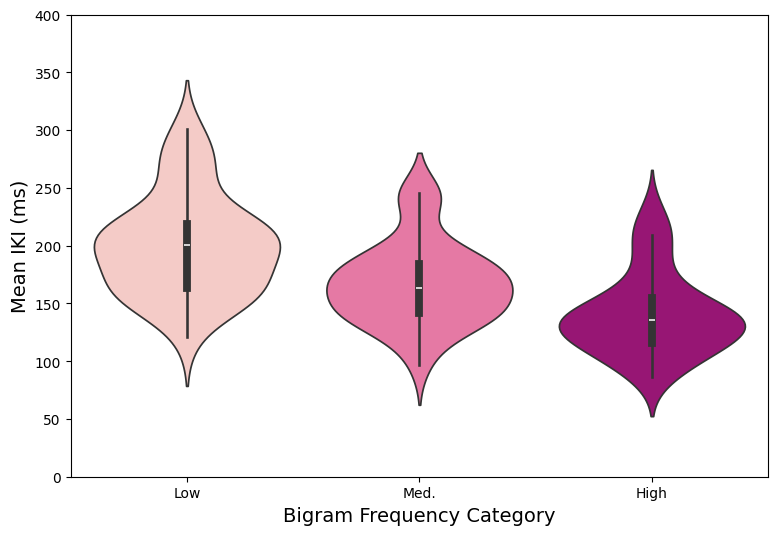

In [23]:
# Mean IKI | Bigram Freq. - white background
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bybf, 
    x="bf_type", 
    y="mean_IKI", 
    hue='bf_type', 
    palette='RdPu'
)

ax.set(
    xlabel='Bigram Frequency Category', 
    ylabel='Mean IKI (ms)',
    xticks=[0, 1, 2],
    xticklabels=['Low', 'Med.', 'High'],
    ylim=[0, 400]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.savefig(save_dir + 'violin_meanikis_bf.png', dpi=300)
plt.show()

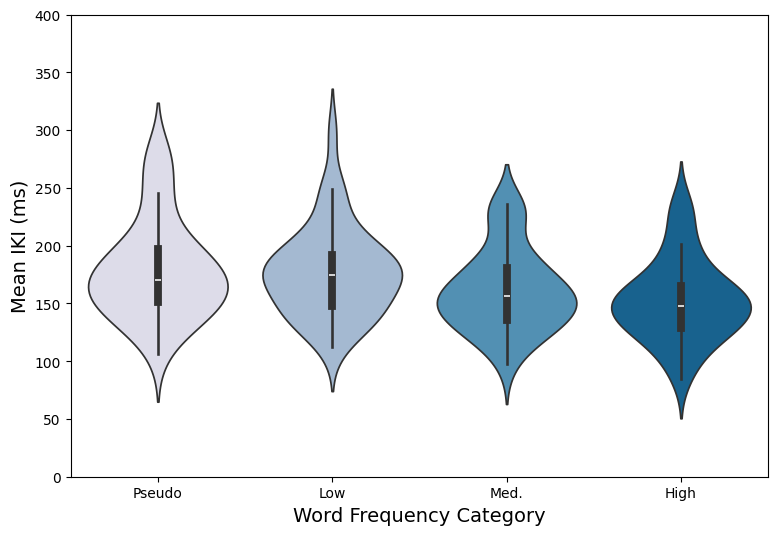

In [24]:
# Mean IKI | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bywf, 
    x="wf_type", 
    y="mean_IKI", 
    hue='wf_type', 
    palette='PuBu'
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='Mean IKI (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 400]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_meanikis_wf.png', dpi=300)
plt.show()

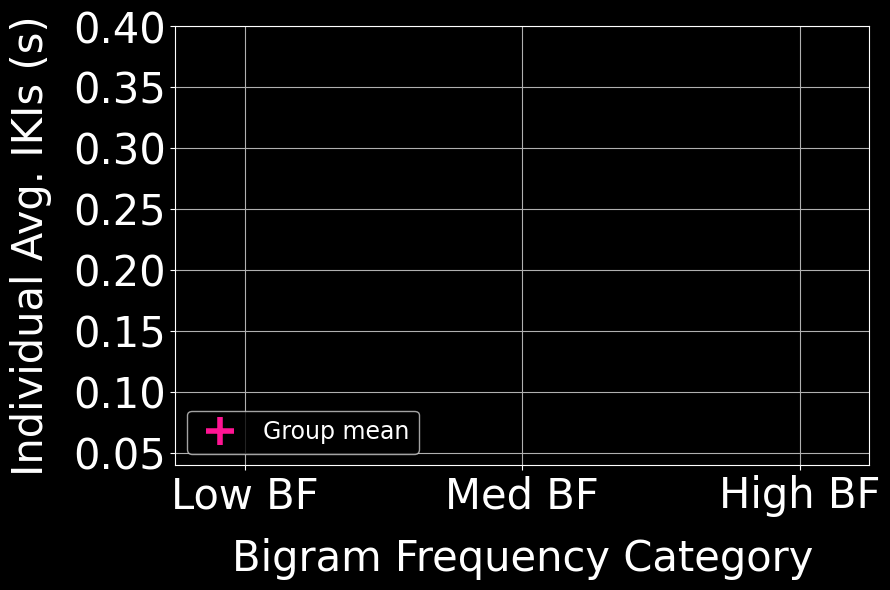

In [25]:
## individual IKI means by BF (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (all_bybf[all_bybf['bf_type'] == 'low']['mean_IKI'], 
     all_bybf[all_bybf['bf_type'] == 'med']['mean_IKI'],
     all_bybf[all_bybf['bf_type'] == 'high']['mean_IKI'])
means = (np.mean(all_bybf[all_bybf['bf_type'] == 'low']['mean_IKI']),
         np.mean(all_bybf[all_bybf['bf_type'] == 'med']['mean_IKI']),
         np.mean(all_bybf[all_bybf['bf_type'] == 'high']['mean_IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.xlim([1.5, 6.5])
plt.ylim([0.04, 0.4])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size=30)
plt.yticks(size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15, size=30)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'mean_ikis_corr_TESTWITHINDIVMEANS.png', dpi=300)
plt.show()

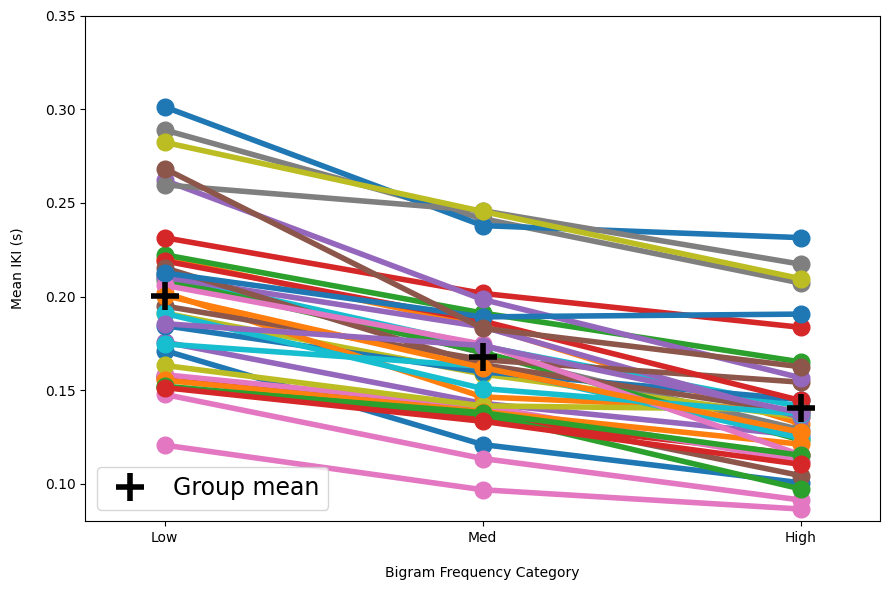

In [26]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')['Avg IKI'],
     indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')['Avg IKI'])
means = (np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg IKI']),
         np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')['Avg IKI']),
         np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.35])
plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean IKI (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig(save_dir + 'indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

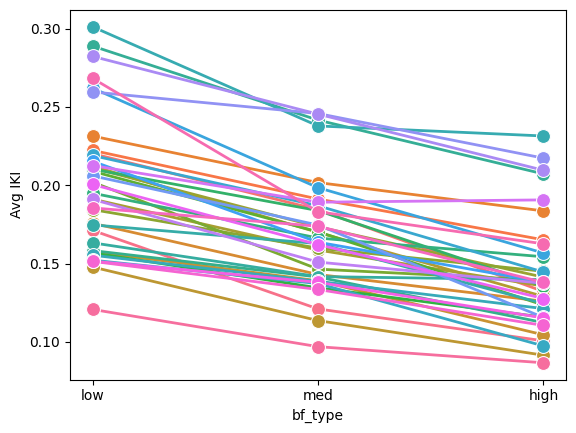

In [27]:
## seaborn version of individuals plot
data = pd.concat([indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf'),
                  indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf'),
                  indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')])

ax = sns.lineplot(data=data, x='bf_type', y='Avg IKI', hue='sID', marker = 'o', markersize = 10, linewidth = 2)
ax.get_legend().set_visible(False)
plt.show()

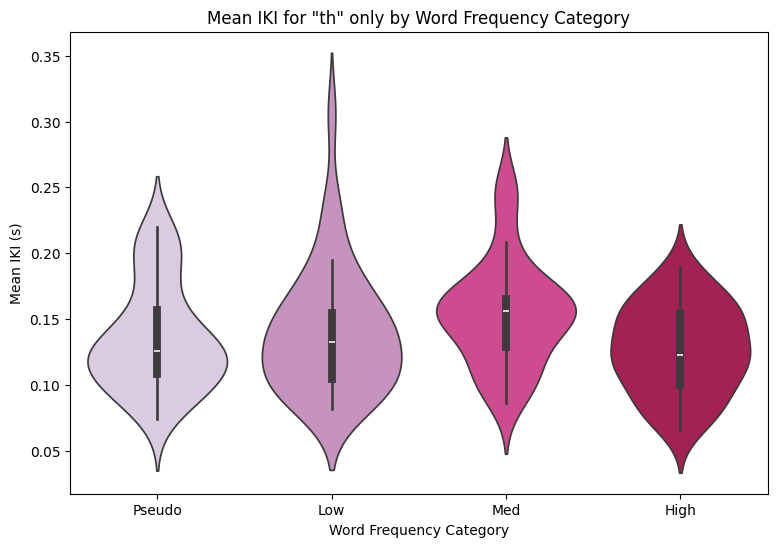

In [28]:
## Mean IKI for 'th' across WF (correct trials only)
# sns.set_style("ticks", rc=custom)
# sns.set_context('talk')
# plt.style.use("dark_background")

th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 'he']

data = {'Pseudo' : indiv_meanikis(th_df, 'string', 'pseudo')['Avg IKI'],
        'Low': indiv_meanikis(th_df, 'string', 'lowwf')['Avg IKI'], 
        'Med': indiv_meanikis(th_df, 'string', 'medwf')['Avg IKI'],
        'High': indiv_meanikis(th_df, 'string', 'highwf')['Avg IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean IKI (s)')
ax.set(xlabel='Word Frequency Category')
# ax.set_ylim(-0.02,1)
plt.savefig(save_dir + 'violin_meanikis_thbywf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

<Figure size 640x480 with 0 Axes>

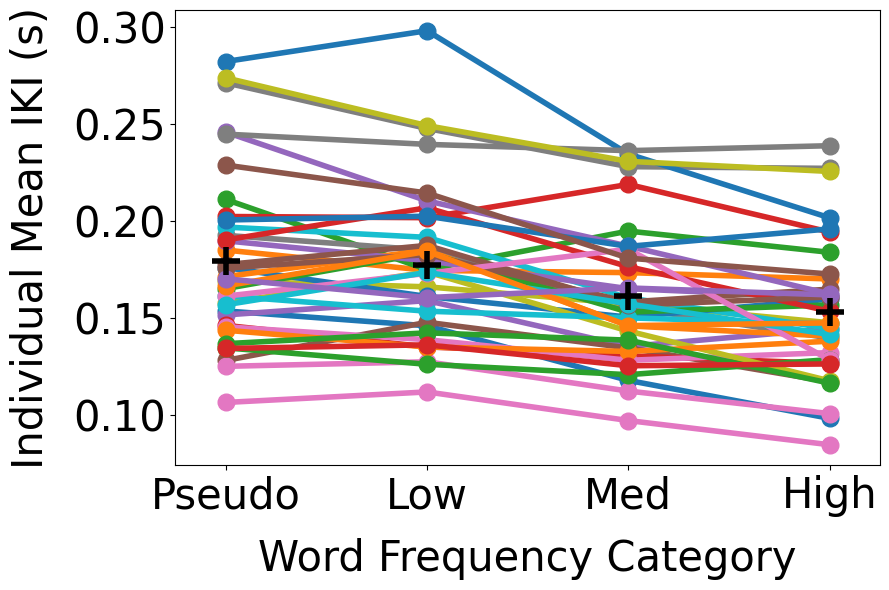

In [29]:
## individual IKI means by WF category
plt.rcParams.update(plt.rcParamsDefault)
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (indiv_meanikis(corr_trials_bybg, 'string', 'pseudo')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'string', 'lowwf')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'string', 'medwf')['Avg IKI'],
    indiv_meanikis(corr_trials_bybg, 'string', 'highwf')['Avg IKI'])

means = (np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'pseudo')['Avg IKI']), 
         np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'lowwf')['Avg IKI']), 
         np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'medwf')['Avg IKI']),
        np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'highwf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize = 30)
plt.ylabel("Individual Mean IKI (s)", labelpad=15, fontsize = 30)
plt.title("")
# plt.legend(loc="best")

fig.tight_layout()
# plt.savefig(save_dir + 'indiv_mean_ikis.png', dpi=300)
plt.show()

In [30]:
np.sqrt(len(corr_trials_bybg.IKI))

181.41664752717708

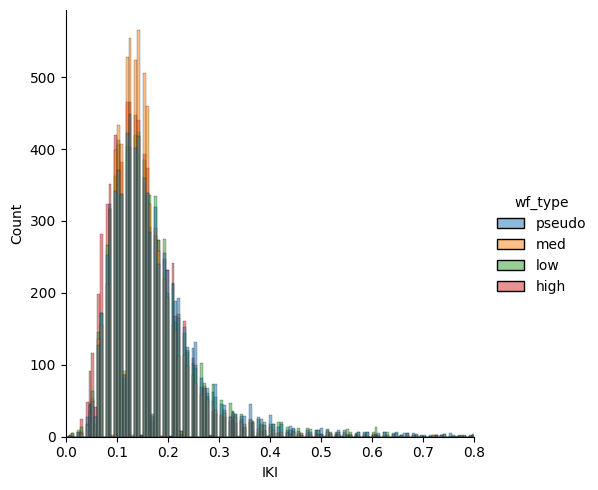

In [31]:
## histograms of mean IKI by WF
# sns.set(rc={"figure.figsize":(9, 6)})
sns.displot(corr_trials_bybg, x='IKI', hue='wf_type', bins=177)
plt.xlim(0, 0.8)
plt.show()

# SD IKI
___

## SD IKI Statistics

In [32]:
# Runs one-way, repeated measures ANOVA:
# individual SD IKI | bigram frequency
print(pg.rm_anova(all_bybf, 'sd_IKI', 'bf_type', 'sID'))
pg.pairwise_tukey(all_bybf, 'sd_IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc     p-GG-corr      ng2  \
0  bf_type      2     72  103.119791  7.326372e-22  4.695345e-18  0.32276   

        eps  sphericity  W-spher   p-spher  
0  0.804421       False  0.75687  0.007636  


A    B     mean(A)     mean(B)       diff        se         T  \
0  high  low   61.186059  105.531165 -44.345106  6.371241 -6.960199   
1  high  med   61.186059   73.759602 -12.573543  6.371241 -1.973484   
2   low  med  105.531165   73.759602  31.771563  6.371241  4.986715   

        p-tukey     cohen  
0  8.251568e-10 -1.570420  
1  1.237119e-01 -0.513186  
2  7.018415e-06  1.086419

In [33]:
# Runs one-way, repeated measures ANOVA:
# individual SD IKI | average bigram frequency
print(pg.rm_anova(all_byavgbf, 'sd_IKI', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_byavgbf, 'sd_IKI', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2           F         p-unc     p-GG-corr       ng2  \
0  avgbf_type      2     72  103.564203  6.531676e-22  7.448338e-18  0.294159   

        eps  sphericity   W-spher   p-spher  
0  0.792103       False  0.737538  0.004855  


A    B     mean(A)     mean(B)       diff        se         T  \
0  high  low   61.530186  101.891638 -40.361452  6.230971 -6.477554   
1  high  med   61.530186   72.286455 -10.756269  6.230971 -1.726259   
2   low  med  101.891638   72.286455  29.605183  6.230971  4.751295   

        p-tukey     cohen  
0  8.512031e-09 -1.476226  
1  2.001088e-01 -0.451274  
2  1.858090e-05  1.022001

In [34]:
# Runs one-way, repeated measures ANOVA:
# individual SD IKI | word frequency
print(pg.rm_anova(all_bywf, 'sd_IKI', 'wf_type', 'sID'))
pg.pairwise_tukey(all_bywf, 'sd_IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2         F         p-unc       ng2       eps
0  wf_type      3    108  36.77161  1.869081e-16  0.223504  0.918391


A       B   mean(A)    mean(B)       diff        se         T  \
0  high     low  61.23804  97.421410 -36.183370  6.575052 -5.503130   
1  high     med  61.23804  72.983130 -11.745090  6.575052 -1.786311   
2  high  pseudo  61.23804  94.124333 -32.886293  6.575052 -5.001678   
3   low     med  97.42141  72.983130  24.438280  6.575052  3.716819   
4   low  pseudo  97.42141  94.124333   3.297077  6.575052  0.501453   
5   med  pseudo  72.98313  94.124333 -21.141203  6.575052 -3.215366   

        p-tukey     cohen  
0  9.898631e-07 -1.418137  
1  2.841170e-01 -0.490811  
2  9.658267e-06 -1.244560  
3  1.625049e-03  0.814008  
4  9.586090e-01  0.102887  
5  8.648921e-03 -0.686433

## SD IKI Figures

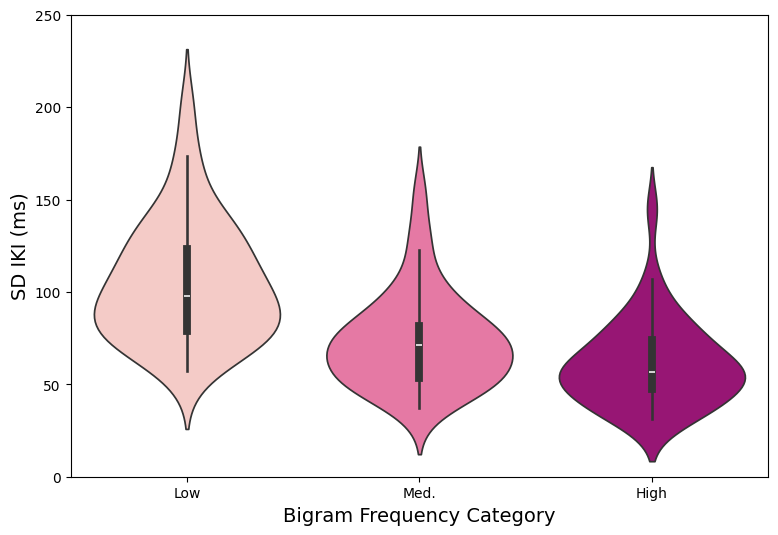

In [35]:
# SD IKI | Bigram Freq. - white background
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bybf, 
    x="bf_type", 
    y="sd_IKI", 
    hue='bf_type', 
    palette='RdPu'
)

ax.set(
    xlabel='Bigram Frequency Category', 
    ylabel='SD IKI (ms)',
    xticks=[0, 1, 2],
    xticklabels=['Low', 'Med.', 'High'],
    ylim=[0, 250]
)

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_sdiki_bf.png', dpi=300)
plt.show()

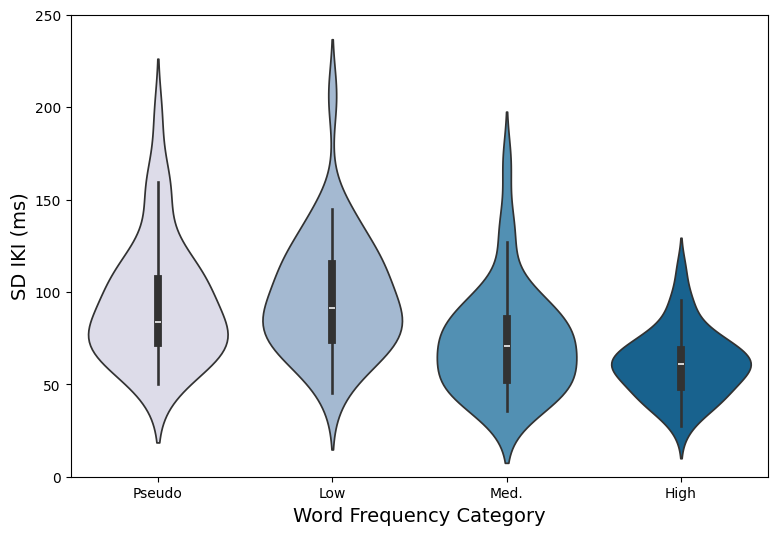

In [36]:
# SD IKI | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bywf, 
    x="wf_type", 
    y="sd_IKI", 
    hue='wf_type', 
    palette='PuBu'
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='SD IKI (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 250]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_sdiki_wf.png', dpi=300)
plt.show()

In [37]:
# ## individual MEAN SD IKI by BF (correct trials)
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6]
# D = (indiv_sdikis(tight_bgs, 'bigram', 'lowbf_norep')['Avg SD IKI'], 
#      indiv_sdikis(tight_bgs, 'bigram', 'medbf_norep')['Avg SD IKI'],
#      indiv_sdikis(tight_bgs, 'bigram', 'highbf')['Avg SD IKI'])
# means = (np.mean(indiv_sdikis(tight_bgs, 'bigram', 'lowbf_norep')['Avg SD IKI']), 
#          np.mean(indiv_sdikis(tight_bgs, 'bigram', 'medbf_norep')['Avg SD IKI']),
#          np.mean(indiv_sdikis(tight_bgs, 'bigram', 'highbf')['Avg SD IKI']))

# fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')
# ax.set_facecolor('black')

# # cm = plt.get_cmap('tab20')
# # for index, data in enumerate(ID_list):
# #     if index == len(ID_list)-1:
# #         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
# #     else:
# #         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

# ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
# ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([0.01, 0.07])
# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size=30)
# plt.yticks(size = 30)
# plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
# plt.ylabel("Indiv. Avg. SD IKI (s)", labelpad=15, size=30)
# plt.grid(visible=None)

# plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# plt.savefig(save_dir + 'meansds_bybf_corr.png', dpi=300, transparent = True)
# plt.show()

In [38]:
# ## mean CV IKI for 'th' by WF (correct trials only)
# th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 're']

# data = {'Pseudo' : indiv_sdikis(th_df, 'string', 'pseudo')['Avg SD IKI'], 
#         'Low': indiv_sdikis(th_df, 'string', 'lowwf')['Avg SD IKI'], 
#         'Med' : indiv_sdikis(th_df, 'string', 'medwf')['Avg SD IKI'],
#         'High' : indiv_sdikis(th_df, 'string', 'highwf')['Avg SD IKI']}
# DF = pd.DataFrame(data)

# # sns.set(rc={"figure.figsize":(9, 6)})
# fig, ax = plt.subplots(figsize=(9,6))
# # sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='PuRd', ax=ax)
# ax.set(title = 'Mean SD IKI for "th" only by Word Frequency Category')
# ax.set(ylabel='Mean SD IKI (s)')
# ax.set(xlabel='Word Frequency Category')
# # ax.set_ylim(-0.02, 0.30)

# plt.savefig(save_dir + 'violin_meansds_thbywf_corr.png', dpi=300)
# plt.show()

# CV IKI
___

## CV IKI Statistics

In [39]:
# Runs one-way, repeated measures ANOVA:
# individual CV IKI | bigram frequency
print(pg.rm_anova(all_bybf, 'cv_IKI', 'bf_type', 'sID'))
pg.pairwise_tukey(all_bybf, 'cv_IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     72  24.077481  9.846191e-09  0.151228  0.864066


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.433073  0.522381 -0.089308  0.023231 -3.844317  0.000596   
1  high  med  0.433073  0.435220 -0.002147  0.023231 -0.092438  0.995300   
2   low  med  0.522381  0.435220  0.087161  0.023231  3.751879  0.000825   

      cohen  
0 -0.875625  
1 -0.020760  
2  0.926521

In [40]:
# Runs one-way, repeated measures ANOVA:
# individual mean CV | average bigram frequency
print(pg.rm_anova(all_byavgbf, 'cv_IKI', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_byavgbf, 'cv_IKI', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2          F     p-unc       ng2       eps
0  avgbf_type      2     72  14.116558  0.000007  0.077075  0.884133


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.429789  0.497572 -0.067784  0.022961 -2.952115  0.010728   
1  high  med  0.429789  0.452713 -0.022924  0.022961 -0.998382  0.579478   
2   low  med  0.497572  0.452713  0.044860  0.022961  1.953733  0.128833   

      cohen  
0 -0.701957  
1 -0.225008  
2  0.458902

In [41]:
## anova for cvs (by word freq)
print(pg.rm_anova(all_bywf, 'cv_IKI', 'wf_type', 'sID'))
pg.pairwise_tukey(all_bywf, 'cv_IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    108  29.711564  4.382044e-14  0.250384  0.934427


A       B   mean(A)   mean(B)      diff        se         T  \
0  high     low  0.399582  0.544755 -0.145173  0.023621 -6.145938   
1  high     med  0.399582  0.444791 -0.045209  0.023621 -1.913934   
2  high  pseudo  0.399582  0.519387 -0.119804  0.023621 -5.071959   
3   low     med  0.544755  0.444791  0.099964  0.023621  4.232004   
4   low  pseudo  0.544755  0.519387  0.025368  0.023621  1.073979   
5   med  pseudo  0.444791  0.519387 -0.074595  0.023621 -3.158025   

        p-tukey     cohen  
0  4.420065e-08 -1.565140  
1  2.267700e-01 -0.455175  
2  7.078027e-06 -1.377195  
3  2.381679e-04  0.874171  
4  7.059235e-01  0.244342  
5  1.033187e-02 -0.679806

## CV IKI Figures

In [42]:
## making dataframe of cv values
cv_df = pd.concat(
    [indiv_cvikis(all_bigrams, 'bigram', 'highbf'),
    indiv_cvikis(all_bigrams, 'bigram', 'medbf').rename(columns = {'Avg CV IKI': 'meanCV_med'})['meanCV_med'],
    indiv_cvikis(all_bigrams, 'bigram', 'lowbf').rename(columns = {'Avg CV IKI': 'meanCV_low'})['meanCV_low']], 
    axis = 1)
cv_df = cv_df.rename(columns = {cv_df.columns[1]: 'meanCV_high'})
# cv_df

In [43]:
all_bybf.groupby('bf_type').cv_IKI.agg('std')

bf_type
high    0.110695
low     0.092478
med     0.095642
Name: cv_IKI, dtype: float64

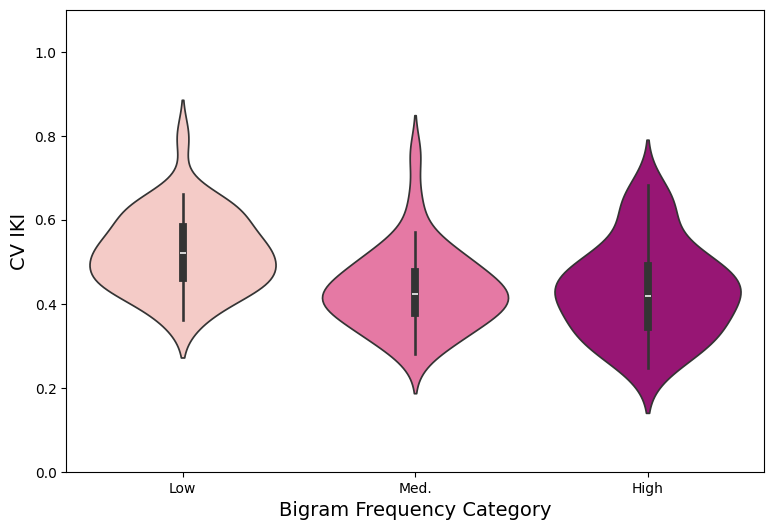

In [44]:
# CV IKI | Bigram Freq. - white background
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bybf, 
    x="bf_type", 
    y="cv_IKI", 
    hue='bf_type', 
    palette='RdPu',
)

ax.set(
    xlabel='Bigram Frequency Category', 
    ylabel='CV IKI',
    xticks=[0, 1, 2],
    xticklabels=['Low', 'Med.', 'High'],
    ylim=[0, 1.1]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_cviki_bf.png', dpi=300)
plt.show()

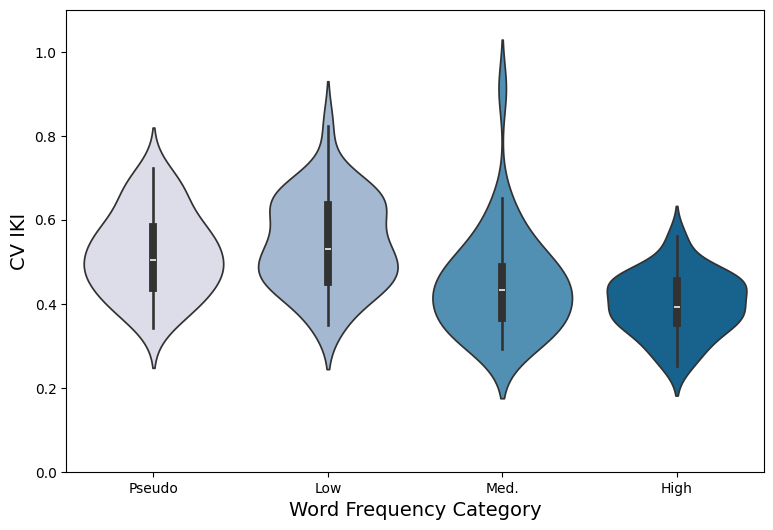

In [45]:
# CV IKI | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bywf, 
    x="wf_type", 
    y="cv_IKI", 
    hue='wf_type', 
    palette='PuBu',
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='CV IKI',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 1.1]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_cviki_wf.png', dpi=300)
plt.show()

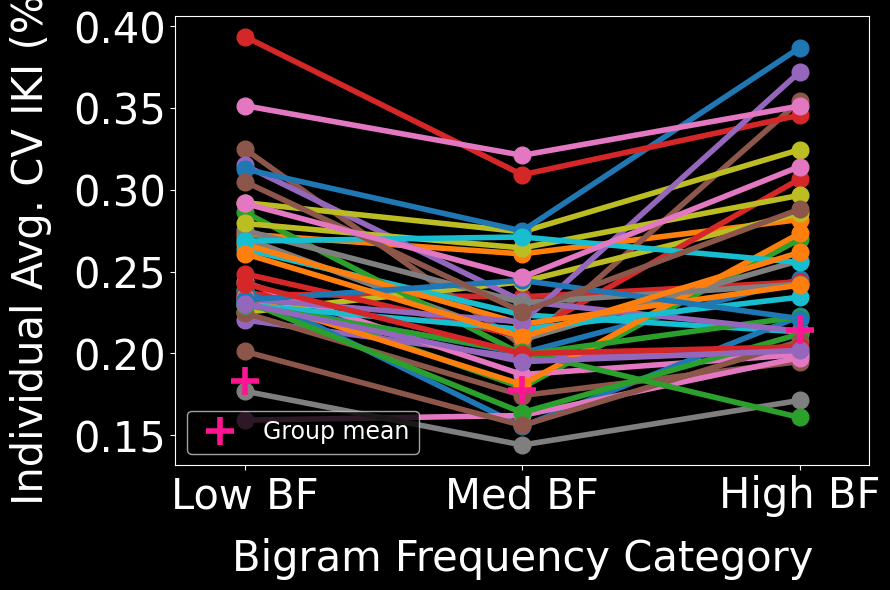

In [46]:
## Individual MEAN CV IKIs sorted by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI'])
means = (np.mean(indiv_cvikis(tight_bgs, 'bigram', 'lowbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(tight_bgs, 'bigram', 'medbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(tight_bgs, 'bigram', 'highbf')['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([0.1, 0.5])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size = 30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size = 30)
plt.yticks(size=30)
plt.ylabel("Individual Avg. CV IKI (%)", labelpad=15, size = 30)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'cvikis_bybf_corr.png', dpi=300, transparent = True)
plt.show()

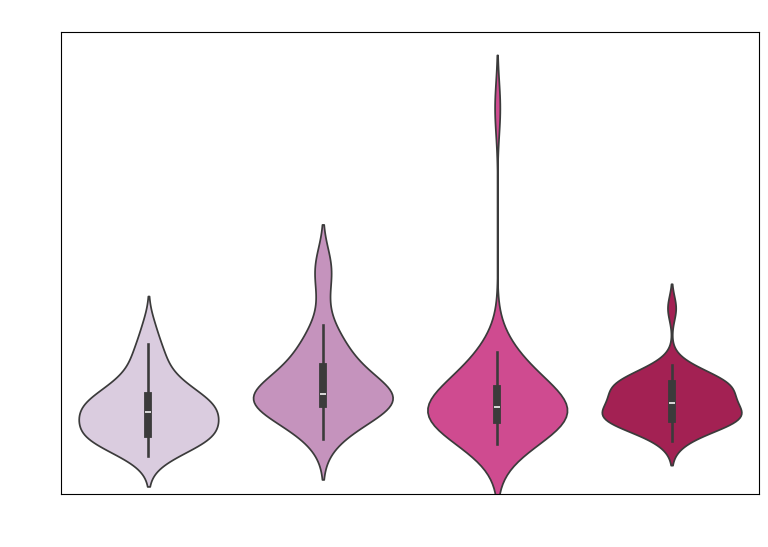

In [47]:
## Mean CV IKI for 'th' across WF (correct trials only)
th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 'th']

data = {'Pseudo' : indiv_cvikis(th_df, 'string', 'pseudo')['Avg CV IKI'], 
        'Low': indiv_cvikis(th_df, 'string', 'lowwf')['Avg CV IKI'], 
        'Med' : indiv_cvikis(th_df, 'string', 'medwf')['Avg CV IKI'],
        'High' : indiv_cvikis(th_df, 'string', 'highwf')['Avg CV IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean CV IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean CV IKI (s)')
ax.set(xlabel='Word Frequency Category')
ax.set_ylim(-0.03, 1)

plt.savefig(save_dir + 'violin_meancvs_thbywf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

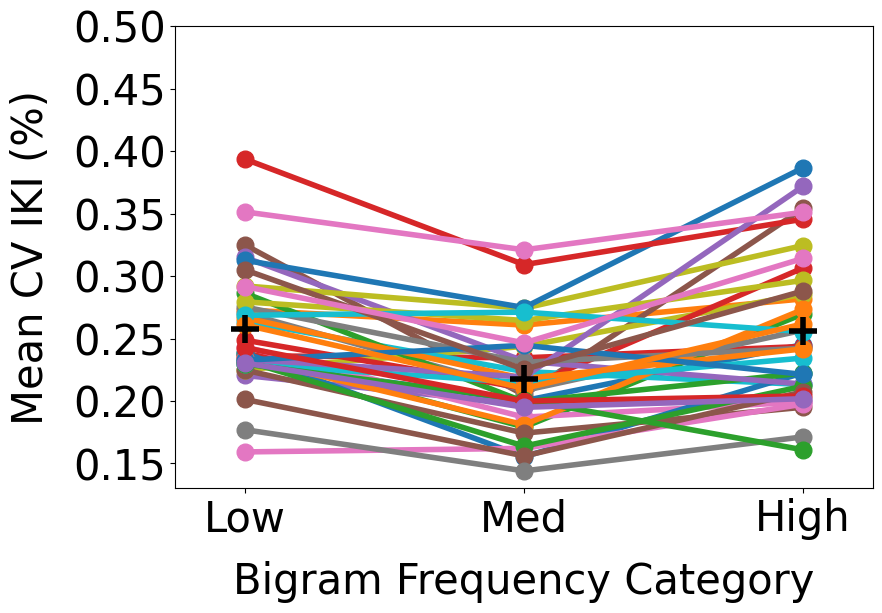

In [48]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI'])
means = (np.mean(indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.13, 0.5])
plt.xticks(x, ('Low', 'Med', 'High'), size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)

plt.yticks(size=30)
plt.ylabel("Mean CV IKI (%)", labelpad=15, size=30)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig(save_dir + 'indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

# Mean, SD, & CV RT

______

## RT Statistics

In [49]:
# ## NOT RELEVANT FOR MANUSCRIPT ##

# ## finding indices of trials that occur after an error
# err_indices = list(all_trials[all_trials['trial_corr'] == 'incorr'].index.values)
# posterr_indices = list(map(lambda x: x + 1, err_indices))

# ## making dataframe of only post-error trial reaction times
# all_rts = corr_trials[['sID', 'key_resp.rt.1', 'wf_type']]
# posterr_rts = all_rts.filter(posterr_indices, axis=0)

# ## making dataframe of only post-success trial reaction times
# all_indices = list(all_trials.index.values)
# bad_indices = (err_indices + posterr_indices)
# postsucc_indices = list(filter(lambda x: x not in set(bad_indices), all_indices))
# postsucc_rts = all_rts.filter(postsucc_indices, axis=0)

In [50]:
# Creates dataframes of RT metric values for average bigram and word frequencies.
rt_byavgbf = indiv_rtmetric(corr_trials, avgbf_groups, iki_metrics)
rt_bywf = indiv_rtmetric(corr_trials, wf_groups, iki_metrics)

In [51]:
# Runs one-way, repeated measures ANOVA:
# individual mean RT | word frequency
print(pg.rm_anova(rt_bywf, 'mean_RT', 'wf_type', 'sID'))
pg.pairwise_tukey(rt_bywf, 'mean_RT', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  wf_type      3    108  100.94036  3.345440e-31  8.127584e-21  0.136954   

        eps  sphericity   W-spher  p-spher  
0  0.638961       False  0.448764  0.00004  


A       B     mean(A)     mean(B)        diff         se         T  \
0  high     low  744.102742  804.173762  -60.071020  34.071798 -1.763072   
1  high     med  744.102742  777.421288  -33.318545  34.071798 -0.977892   
2  high  pseudo  744.102742  898.802587 -154.699844  34.071798 -4.540407   
3   low     med  804.173762  777.421288   26.752475  34.071798  0.785179   
4   low  pseudo  804.173762  898.802587  -94.628825  34.071798 -2.777336   
5   med  pseudo  777.421288  898.802587 -121.381299  34.071798 -3.562515   

    p-tukey     cohen  
0  0.295436 -0.436624  
1  0.762254 -0.261303  
2  0.000069 -0.989749  
3  0.861085  0.196569  
4  0.031223 -0.579181  
5  0.002778 -0.783114

In [52]:
# Runs one-way, repeated measures ANOVA:
# individual SD RT | word frequency
print(pg.rm_anova(rt_bywf, 'sd_RT', 'wf_type', 'sID'))
pg.pairwise_tukey(rt_bywf, 'sd_RT', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc  p-GG-corr       ng2  \
0  wf_type      3    108  12.208604  6.112796e-07   0.000005  0.097796   

       eps  sphericity   W-spher   p-spher  
0  0.81004       False  0.707295  0.034522  


A       B     mean(A)     mean(B)       diff         se         T  \
0  high     low  125.411117  139.832248 -14.421132  13.457441 -1.071610   
1  high     med  125.411117  137.769675 -12.358559  13.457441 -0.918344   
2  high  pseudo  125.411117  175.839230 -50.428114  13.457441 -3.747229   
3   low     med  139.832248  137.769675   2.062573  13.457441  0.153266   
4   low  pseudo  139.832248  175.839230 -36.006982  13.457441 -2.675619   
5   med  pseudo  137.769675  175.839230 -38.069555  13.457441 -2.828885   

    p-tukey     cohen  
0  0.707353 -0.253473  
1  0.795094 -0.228019  
2  0.001459 -0.888397  
3  0.998712  0.034970  
4  0.041014 -0.586959  
5  0.027091 -0.646841

In [53]:
# Runs one-way, repeated measures ANOVA:
# individual CV RT | word frequency
print(pg.rm_anova(rt_bywf, 'cv_RT', 'wf_type', 'sID'))
pg.pairwise_tukey(rt_bywf, 'cv_RT', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc       ng2       eps
0  wf_type      3    108  3.055996  0.031497  0.038874  0.828373


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.164333  0.167682 -0.003349  0.012764 -0.262403  0.993646   
1  high     med  0.164333  0.173135 -0.008802  0.012764 -0.689613  0.900924   
2  high  pseudo  0.164333  0.192466 -0.028133  0.012764 -2.204062  0.127019   
3   low     med  0.167682  0.173135 -0.005453  0.012764 -0.427211  0.973735   
4   low  pseudo  0.167682  0.192466 -0.024784  0.012764 -1.941659  0.215409   
5   med  pseudo  0.173135  0.192466 -0.019331  0.012764 -1.514448  0.431540   

      cohen  
0 -0.060577  
1 -0.155346  
2 -0.533766  
3 -0.095649  
4 -0.466910  
5 -0.354638

## RT Figures

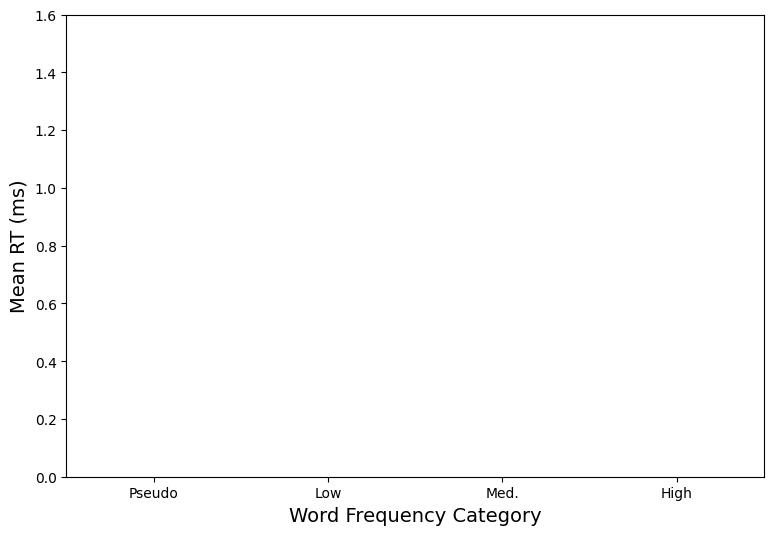

In [54]:
# Mean RT | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=rt_bywf, 
    x="wf_type", 
    y="mean_RT", 
    hue='wf_type', 
    palette='YlGn',
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='Mean RT (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 1.6]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_meanrt_wf.png', dpi=300)
plt.show()

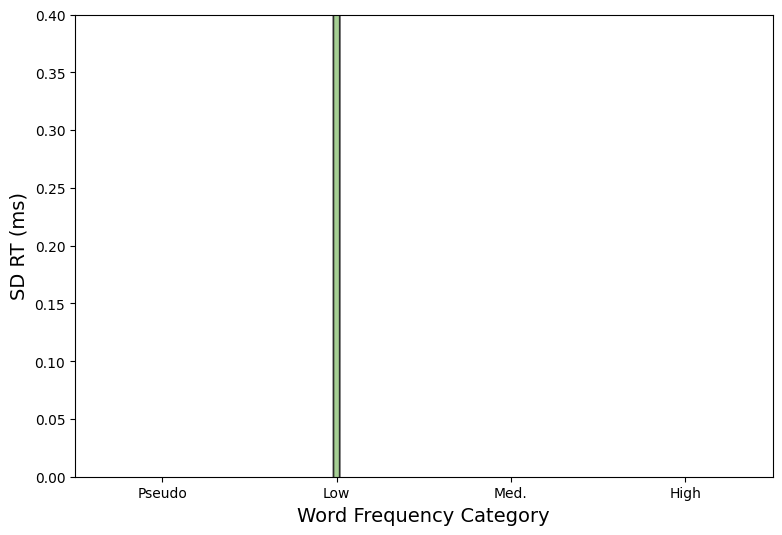

In [55]:
# SD RT | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=rt_bywf, 
    x="wf_type", 
    y="sd_RT", 
    hue='wf_type', 
    palette='YlGn',
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='SD RT (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 0.4]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_sdrt_wf.png', dpi=300)
plt.show()

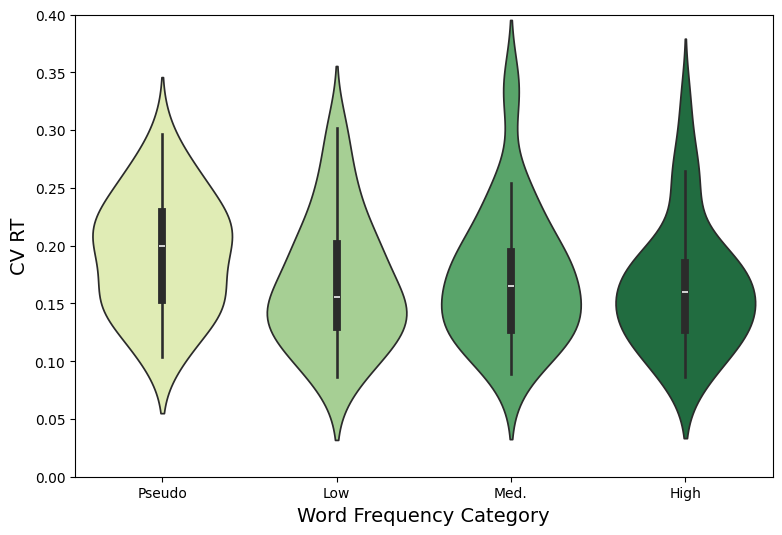

In [56]:
# CV RT | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=rt_bywf, 
    x="wf_type", 
    y="cv_RT", 
    hue='wf_type', 
    palette='YlGn',
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='CV RT',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 0.4]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_cvrt_wf.png', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

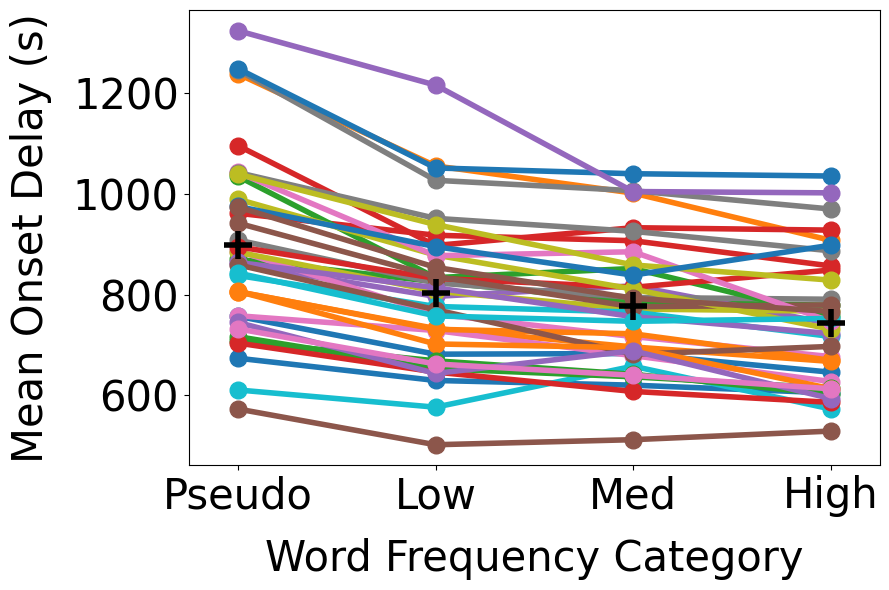

In [57]:
## plotting average onset delays by WF group
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (rt_bywf[rt_bywf['wf_type'] == 'pseudo']['mean_RT'],
    rt_bywf[rt_bywf['wf_type'] == 'low']['mean_RT'],
    rt_bywf[rt_bywf['wf_type'] == 'med']['mean_RT'],
    rt_bywf[rt_bywf['wf_type'] == 'high']['mean_RT'])

means = (np.mean(rt_bywf[rt_bywf['wf_type'] == 'pseudo']['mean_RT']),
        np.mean(rt_bywf[rt_bywf['wf_type'] == 'low']['mean_RT']),
        np.mean(rt_bywf[rt_bywf['wf_type'] == 'med']['mean_RT']),
        np.mean(rt_bywf[rt_bywf['wf_type'] == 'high']['mean_RT']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meanod_bywf.png', dpi=300)
plt.show()

# Total Trial Error
___

## Total Trial Error Statistics

In [58]:
## anova for error rates (by bg freq)
all_errors_bybf = all_ikimetric(indiv_error, incorr_bgs, 
                                   'bigram', bf_groups)

total_bigrams = pd.DataFrame(all_bigrams.groupby(['sID', 
                                                  'bf_type']).size()).reset_index()
total_bigrams = total_bigrams.reset_index(drop=True).rename(columns={0:'bigrams'})

all_errors_bybf['relative_error'] = all_errors_bybf['total_error'] / total_bigrams['bigrams']

print(pg.rm_anova(all_errors_bybf, 'relative_error', 'bf_type', 'sID'))

# pg.pairwise_tukey(all_errors_bybf, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2        F     p-unc       ng2      eps
0  bf_type      2     72  1.87186  0.161247  0.016778  0.79443


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


In [59]:
## anova for error rates (by avg bg freq)
all_errors_byavgbf = all_ikimetric(indiv_error, incorr_trials, 
                                   'string', avgbf_groups)

print(pg.rm_anova(all_errors_byavgbf, 'total_error', 'avgbf_type', 'sID'))

pg.pairwise_tukey(all_errors_byavgbf, 'total_error', 
                  'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2  \
0  avgbf_type      2     72  5.629242  0.005352   0.008559  0.048834   

        eps  sphericity   W-spher   p-spher  
0  0.838966       False  0.808056  0.024001  


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  4.459459  6.540541 -2.081081  0.899173 -2.314440  0.058032   
1  high  med  4.459459  5.162162 -0.702703  0.899173 -0.781499  0.715166   
2   low  med  6.540541  5.162162  1.378378  0.899173  1.532941  0.279651   

      cohen  
0 -0.534280  
1 -0.202360  
2  0.328168

In [60]:
## anova for error rates (by word freq)
all_errors_bywf = all_ikimetric(indiv_error, incorr_trials, 
                                'string', wf_groups)

total_trials = pd.DataFrame(all_trials.groupby(['sID', 'wf_type']).size()).reset_index()
total_trials = total_trials.reset_index(drop=True).rename(columns={0:'trials'})

all_errors_bywf['relative_error'] = all_errors_bywf['total_error'] / total_trials['trials']

print(pg.rm_anova(all_errors_bywf, 'total_error', 'wf_type', 'sID'))

    Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  wf_type      3    108  2.262118  0.085354   0.101415  0.023265  0.785702   

   sphericity   W-spher  p-spher  
0       False  0.639857  0.00844  


## Trial Error Figures

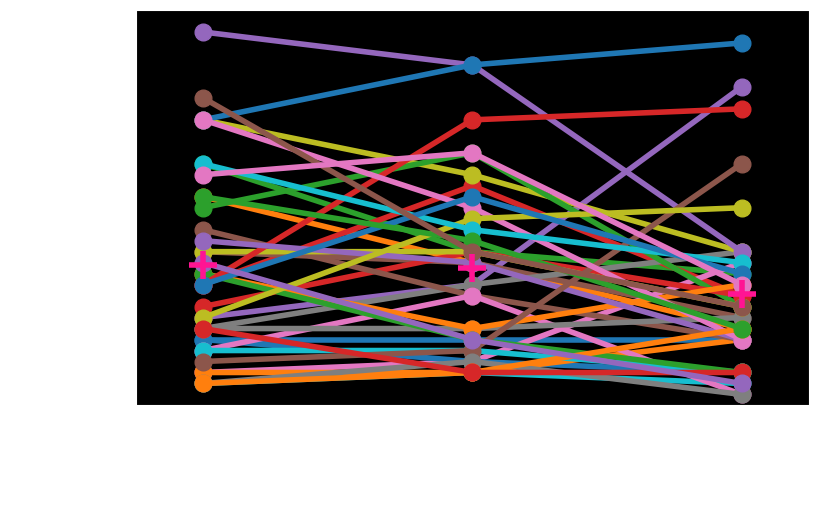

In [61]:
## Individual total trial error by bigram BF
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_bgs, 'bigram', 'lowbf')['total_error'], 
     indiv_error(incorr_bgs, 'bigram', 'medbf')['total_error'],
     indiv_error(incorr_bgs, 'bigram', 'highbf')['total_error'])

means = (np.mean(indiv_error(incorr_bgs, 'bigram', 'lowbf')['total_error']), 
         np.mean(indiv_error(incorr_bgs, 'bigram', 'medbf')['total_error']),
         np.mean(indiv_error(incorr_bgs, 'bigram', 'highbf')['total_error']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([-1, 35])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'meanerr_bybf.png', dpi=300)
plt.show()

In [62]:
## Individual total trial error by AVG BF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6]
# D = (indiv_error(incorr_trials, 'string', 'avg_lowbf')['Total Error'], 
#      indiv_error(incorr_trials, 'string', 'avg_medbf')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'avg_highbf')['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
# plt.xlabel("Average Bigram Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# plt.savefig(save_dir + 'indiv_sdikis.png', dpi=300)
# plt.show()

In [63]:
## Individual total trial error by WF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6, 8]

# D = (indiv_error(incorr_trials, 'string', 'pseudo')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'lowwf')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'medwf')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'highwf')['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# print([len(x) for x in D])
# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 8.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
# plt.xlabel("Word Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# # plt.savefig(save_dir + 'indiv_sdikis.png', dpi=300)
# plt.show()

# Delta RT

In [64]:
# Calculates the change in reaction time (delta RT) across consecutive 
# repetitions of the same string.
def deltart(dataframe):
    deltarts = pd.DataFrame(dataframe.groupby(['sID', 
                                               'string']).RT.agg(['diff']))
    return deltarts

# Adding 'delta_rt' column to corr_trials dataframe.
corr_trials = corr_trials.assign(delta_rt=deltart(corr_trials))

# Averages delta RTs across frequency groups for each subject and puts into 
# one dataframe.
def indiv_deltart(dataframe, typ_group_list):
    all_deltarts = pd.DataFrame()
    for typ_group in typ_group_list:
        group = getattr(typ, typ_group)
        DF = dataframe[dataframe.string.isin(group)]
        delta_DF = pd.DataFrame(DF)
        delta_DF['delta_rt'] = deltart(DF)
        delta_DF = delta_DF[delta_DF['rep_num'] != 0]
        mean_byindiv = delta_DF.groupby(['sID']).delta_rt.agg(['mean'])
        # mean_byindiv = pd.DataFrame(delta_DF.groupby('sID').agg('mean'))
        mean_deltarts = mean_byindiv.rename(columns={'mean' : 'mean_deltart'}).reset_index()
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            mean_deltarts['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            mean_deltarts['wf_type'] = freq_type
        all_deltarts = pd.concat([all_deltarts, mean_deltarts])
    return all_deltarts

## Delta RT Statistics

In [65]:
## anova on delta reaction time across avg BF
all_deltarts_byavgbf = indiv_deltart(corr_trials, avgbf_groups)

print(pg.rm_anova(all_deltarts_byavgbf, 'mean_deltart', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_deltarts_byavgbf, 'mean_deltart', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2         F     p-unc       ng2       eps
0  avgbf_type      2     72  0.387677  0.680039  0.003367  0.966602


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low -0.015423 -0.014003 -0.001420  0.002568 -0.553041  0.845140   
1  high  med -0.015423 -0.014173 -0.001251  0.002568 -0.486956  0.877647   
2   low  med -0.014003 -0.014173  0.000170  0.002568  0.066085  0.997595   

      cohen  
0 -0.118090  
1 -0.118449  
2  0.016188

In [66]:
## anova on delta reaction time across WF
all_deltarts_bywf = indiv_deltart(corr_trials, wf_groups)

print(pg.rm_anova(all_deltarts_bywf, 'mean_deltart', 'wf_type', 'sID'))
pg.pairwise_tukey(all_deltarts_bywf, 'mean_deltart', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    108  13.105243  2.315836e-07  0.160337  0.875355


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.008901 -0.016577  0.007676  0.003136  2.447722  0.072846   
1  high     med -0.008901 -0.009930  0.001028  0.003136  0.327910  0.987781   
2  high  pseudo -0.008901 -0.023378  0.014477  0.003136  4.616248  0.000050   
3   low     med -0.016577 -0.009930 -0.006648  0.003136 -2.119812  0.151724   
4   low  pseudo -0.016577 -0.023378  0.006801  0.003136  2.168526  0.137033   
5   med  pseudo -0.009930 -0.023378  0.013448  0.003136  4.288337  0.000191   

      cohen  
0  0.571716  
1  0.081690  
2  0.986066  
3 -0.545811  
4  0.474490  
5  0.992470

## Delta RT Figures

<Figure size 640x480 with 0 Axes>

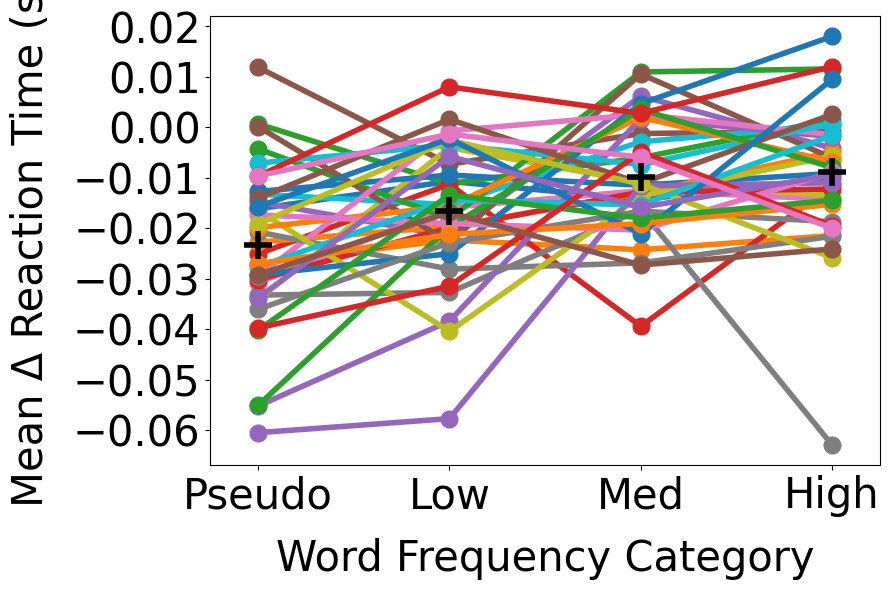

In [67]:
## plotting mean delta onset delays across WF
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')
# plt.rcParams['font.size'] = '30']

x = [2, 4, 6, 8]
D = (all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'pseudo']['mean_deltart'],
    all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'low']['mean_deltart'],
    all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'med']['mean_deltart'],
    all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'high']['mean_deltart'])

means = (np.mean(all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'pseudo']['mean_deltart']),
        np.mean(all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'low']['mean_deltart']),
        np.mean(all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'med']['mean_deltart']),
        np.mean(all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'high']['mean_deltart']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize = 30)
plt.ylabel("Mean Δ Reaction Time (s)", labelpad=15, fontsize = 30)

plt.title("")

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaRT_bywf.png', dpi=300)
plt.show()

In [68]:
pseudo_only = corr_trials[corr_trials['wf_type'] == 'pseudo']
pseudo_rts = pseudo_only.groupby(['sID', 'rep_num']).RT.agg(['mean']).reset_index()

<Figure size 640x480 with 0 Axes>

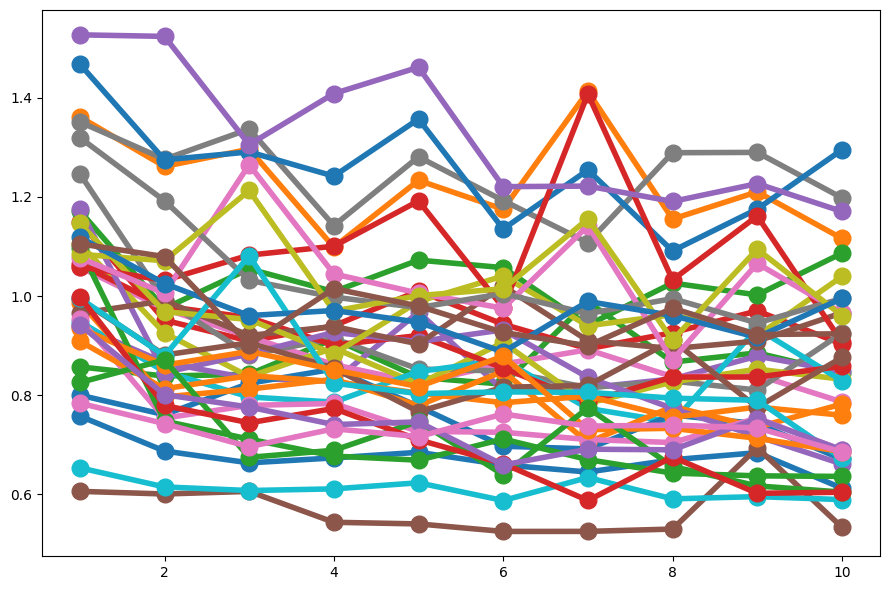

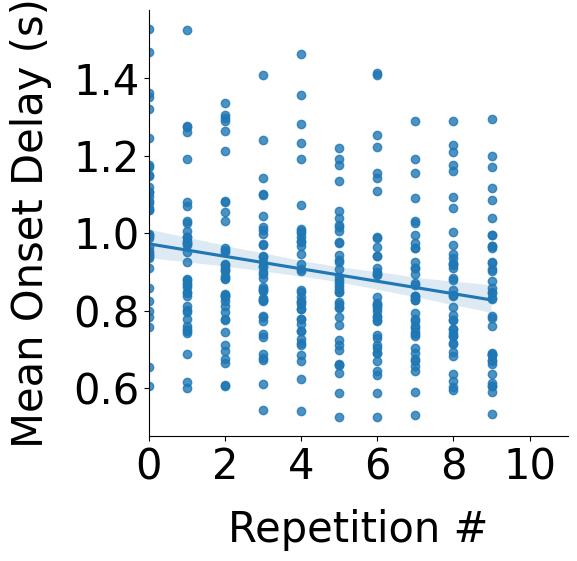

In [69]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = list(range(1,11))
D = (pseudo_rts[pseudo_rts['rep_num'] == 0]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 1]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 2]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 3]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 4]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 5]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 6]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 7]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 8]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 9]['mean'])

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
sns.lmplot(x="rep_num", y="mean", data=pseudo_rts)

# plt.ylim([0.6, 0.65])
plt.xlim([0, 11])
plt.xticks(fontsize=30)
plt.xlabel("Repetition #", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meanod_byrep.png', dpi=300)
plt.show()

In [70]:
## pearson correlation for 
print(pearsonr(pseudo_rts['mean'], pseudo_rts['rep_num']))

PearsonRResult(statistic=-0.23554802176858877, pvalue=4.646871215497189e-06)


## High WF RTs vs. Simulated Null

In [71]:
# Randomly shuffles the RT/IKI values for high freq. bigrams/words for a 
# given participant and calculates the mean delta RT/IKI of each random 
# reshuffle.

def null_deltas(dataframe, metric_column):
    rep_num = 500
    shuff_means = []
    for n in range(0, rep_num):
        for ID in ID_list:
            if 'RT' in metric_column:
                shuff = dataframe[(dataframe['wf_type'] == 'highwf') & 
                                  (dataframe['sID'] == ID)]
                shuff = pd.DataFrame(shuff)
                shuff_vals = np.random.permutation(shuff[metric_column])
                shuff[metric_column] = shuff_vals
                shuff_deltas = deltart(shuff)
                shuff['delta_rt'] = shuff_deltas
                shuff_mean = np.mean(shuff['delta_rt'])
                shuff_means.append([n, ID, shuff_mean])
            if 'IKI' in metric_column:
                for bg_word in ['bf_type', 'wf_type']:
                    shuff = dataframe[(dataframe[bg_word] == 'high') & 
                                      (dataframe['sID'] == ID)]
                    shuff = pd.DataFrame(shuff)
                    shuff_vals = np.random.permutation(shuff[metric_column])
                    shuff[metric_column] = shuff_vals
                    shuff_deltas = deltaiki(shuff)
                    shuff['delta_iki'] = shuff_deltas
                    shuff_mean = np.mean(shuff['delta_iki'])
                    shuff_means.append([n, ID, bg_word, shuff_mean])
    shuff_means = pd.DataFrame(shuff_means)
    # shuff_means.to_csv(save_dir + '/shuff_means_ADDDATEHERE.csv')
    return shuff_means

In [72]:
# # Calcuating mean and STD delta IKI of high freq. bigrams
# highrt_df = all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'high']
# highrt_mean = highrt_df.mean_deltart.mean()
# highrt_std = highrt_df.mean_deltart.std()

# # Creating dataframe of mean delta RTs calculated from shuffled High WF 
# # datasets 
# shuff_rt = null_deltas(corr_trials, 'RT')

# # Saving dataset to report
# # shuff_rt.to_csv(save_dir + '/shuff_highrt_DDMMYYYY.csv')

# # Printing relevant information
# print('Mean delta RT of collected high freq. words', 
#       highrt_mean,
#       '±',
#       highrt_std)

# print('Average of shuffled mean delta RTs', 
#       np.mean(shuff_rt[2]),
#       '±',
#       np.std(shuff_rt[2]))

# p_val = np.mean(abs(shuff_rt[2]) > abs(highrt_mean))
# print('estimated p-val:', p_val)

# # Plotting mean delta RTs of shuffled data and observed value for high freq.
# # words.
# plt.hist(shuff_rt[2], bins=20)
# plt.axvline(x=highrt_mean, color='red', linestyle='--')

# plt.xlabel("Mean delta IKI")
# plt.title("")

# plt.show()

# Delta IKI

In [73]:
# Defining function that calcuates delta IKI from a given dataframe.
def deltaiki(dataframe):
    deltaikis = pd.DataFrame(dataframe.groupby(['sID', 
                                                'string', 
                                                'bigram']).IKI.agg(['diff']))
    # deltaikis.fillna(0, inplace=True)
    return deltaikis

# Adding delta IKI column to corr_trials_bybg dataframe.
corr_trials_bybg = corr_trials_bybg.assign(delta_iki=deltaiki(corr_trials_bybg))

# 
def indiv_meandeltaiki(dataframe, str_or_bg, typ_group_list):
    all_means = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        if str_or_bg == 'string':
            DF = dataframe[dataframe.string.isin(group)]
        elif str_or_bg == 'bigram':
            DF = dataframe[dataframe.bigram.isin(group)]
        delta_DF = pd.DataFrame(DF)
        delta_DF['delta_iki'] = deltaiki(DF)
        delta_DF = delta_DF[delta_DF['rep_num'] != 0]
        deltas = delta_DF.groupby(['sID', 
                                   'string', 
                                   'bigram']).delta_iki.agg(['mean']).reset_index()
        deltas = deltas.rename(columns={'mean' : 'mean_deltaiki'})
        mean_deltaikis = deltas.groupby('sID').mean_deltaiki.agg(['mean']).reset_index()
        mean_deltaikis = mean_deltaikis.rename(columns={'mean' : 'mean_deltaiki'})
        if str_or_bg == 'string':
            if 'avg' in typ_group:
                freq_type = typ_group
                exclude_chars = ['avg_', 'bf']
                for char in exclude_chars:
                    freq_type = freq_type.replace(char, "")
                mean_deltaikis['avgbf_type'] = freq_type
            else:
                freq_type = typ_group.replace('wf', "")
                mean_deltaikis['wf_type'] = freq_type
        elif str_or_bg == 'bigram':
             freq_type = typ_group.replace('bf', "")
             mean_deltaikis['bf_type'] = freq_type
        all_means = pd.concat([all_means, mean_deltaikis])
    all_means = all_means.rename(columns = {'mean': 'mean_IKI',
                                                'stdev': 'sd_IKI',
                                                'variation': 'cv_IKI'})
    return all_means.reset_index()

In [74]:
corr_trials_bybg

sID  bigram_num  trial_num  rep_num  bigram_loc bigram resp_bigram  \
0      s009           0          0        0           0     zi          zi   
1      s009           1          0        0           1     ib          ib   
2      s009           2          0        0           2     bj          bj   
3      s009           3          0        0           3     ja          ja   
4      s009           4          1        0           0     ch          ch   
...     ...         ...        ...      ...         ...    ...         ...   
23064  s311         966        238        9           3     ut          ut   
23065  s311         967        239        9           0     dr          dr   
23066  s311         968        239        9           1     ru          ru   
23067  s311         969        239        9           2     uz          uz   
23068  s311         970        239        9           3     ze          ze   

            IKI string resp_string    bg_freq bf_type meanbf_type wf_type  \
0      0.207861  zibja       zibja    54565.0     low         low  pseudo   
1      0.175981  zibja       zibja   493267.0     low         low  pseudo   
2      0.360005  zibja       zibja   105433.0     low         low  pseudo   
3      0.103974  zibja       zibja    40073.0     low         low  pseudo   
4      0.088020  cheer       cheer  3267507.0     med        high     med   
...         ...    ...         ...        ...     ...         ...     ...   
23064  0.040234  about       about  3257233.0     med         med    high   
23065  0.167842  druze       druze   567936.0     med         low     low   
23066  0.096216  druze       druze   705492.0     med         low     low   
23067  0.103678  druze       druze    19836.0     low         low     low   
23068  0.144187  druze       druze   210896.0     low         low     low   

       trial_corr  bg_corr  delta_iki  
0            True     True        NaN  
1            True     True        NaN  
2            True     True        NaN  
3            True     True        NaN  
4            True     True        NaN  
...           ...      ...        ...  
23064        True     True  -0.015761  
23065        True     True   0.000118  
23066        True     True   0.000264  
23067        True     True  -0.016534  
23068        True     True   0.008255  

[32912 rows x 17 columns]

In [75]:
### TESTING CELL ###


# # # calulating s009s mean IKI for low freq. bigrams using groupby
# test = corr_trials_bybg[(corr_trials_bybg['sID'] == 's009') & (corr_trials_bybg['bf_type'] == 'low')]
# test2 = test.groupby(['string', 'bigram']).delta_iki.agg('mean')
# print(np.mean(test2))
# print(test2)

# # calulating s009s mean IKI for low freq. bigrams using for loops and filtering
# examine = corr_trials_bybg[(corr_trials_bybg['sID'] == 's009') & (corr_trials_bybg['bf_type'] == 'low')]
# another = deltaiki(examine)

# examine2 = []
# for string in another.string.unique():
#     for bigram in another.bigram.unique():
#         filtered = another[(another['string'] == string) & (another['bigram'] == bigram)]
#         filtered_mean = np.mean(filtered['delta_iki'])
#         if math.isnan(filtered_mean) == False:
#             meannfrends = filtered_mean
#             examine2.append(meannfrends)

# examine2
# np.mean(examine2)
# # examine3 = examine2.IKI.mean()
# # examine3
# # np.mean(examine2)

In [76]:
## making dataframe of all individual mean delta IKIs
all_deltas_bybf = indiv_meandeltaiki(corr_trials_bybg, 'bigram', bf_groups)
all_deltas_bywf = indiv_meandeltaiki(corr_trials_bybg, 'string', wf_groups)
all_deltas_bybf

index   sID  mean_deltaiki bf_type
0        0  s009      -0.005433     low
1        1  s020      -0.001539     low
2        2  s175      -0.003633     low
3        3  s176      -0.007789     low
4        4  s178      -0.000970     low
..     ...   ...            ...     ...
106     32  s304      -0.000121    high
107     33  s305      -0.003092    high
108     34  s306      -0.002553    high
109     35  s309      -0.006071    high
110     36  s311      -0.002396    high

[111 rows x 4 columns]

## Delta IKI Statistics

In [77]:
## anova on delta iki comparisons across BF
print(pg.rm_anova(all_deltas_bybf, 'mean_deltaiki', 'bf_type', 'sID', correction=True))
pg.pairwise_tukey(all_deltas_bybf, 'mean_deltaiki', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  bf_type      2     72  24.743092  6.622193e-09  2.388959e-07  0.186522   

        eps  sphericity  W-spher  p-spher  
0  0.769493        True      inf      1.0  


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff       se         T   p-tukey  \
0  high  low -0.001889 -0.005044  0.003155  0.00072  4.382843  0.000080   
1  high  med -0.001889 -0.001997  0.000108  0.00072  0.150478  0.987596   
2   low  med -0.005044 -0.001997 -0.003047  0.00072 -4.232365  0.000143   

      cohen  
0  0.914448  
1  0.045319  
2 -0.912709

In [78]:
## anova on delta iki comparisons across WF
print(pg.rm_anova(all_deltas_bywf, 'mean_deltaiki', 'wf_type', 'sID'))
pg.pairwise_tukey(all_deltas_bywf, 'mean_deltaiki', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    108  11.969074  7.944171e-07  0.136499  0.724465


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.000942 -0.004220  0.003278  0.000787  4.166370  0.000307   
1  high     med -0.000942 -0.002283  0.001341  0.000787  1.704575  0.325073   
2  high  pseudo -0.000942 -0.003948  0.003006  0.000787  3.821244  0.001119   
3   low     med -0.004220 -0.002283 -0.001937  0.000787 -2.461795  0.070413   
4   low  pseudo -0.004220 -0.003948 -0.000271  0.000787 -0.345125  0.985816   
5   med  pseudo -0.002283 -0.003948  0.001665  0.000787  2.116670  0.152710   

      cohen  
0  1.087358  
1  0.577958  
2  0.831884  
3 -0.617382  
4 -0.064874  
5  0.448044

## Delta IKI Figures

<Figure size 640x480 with 0 Axes>

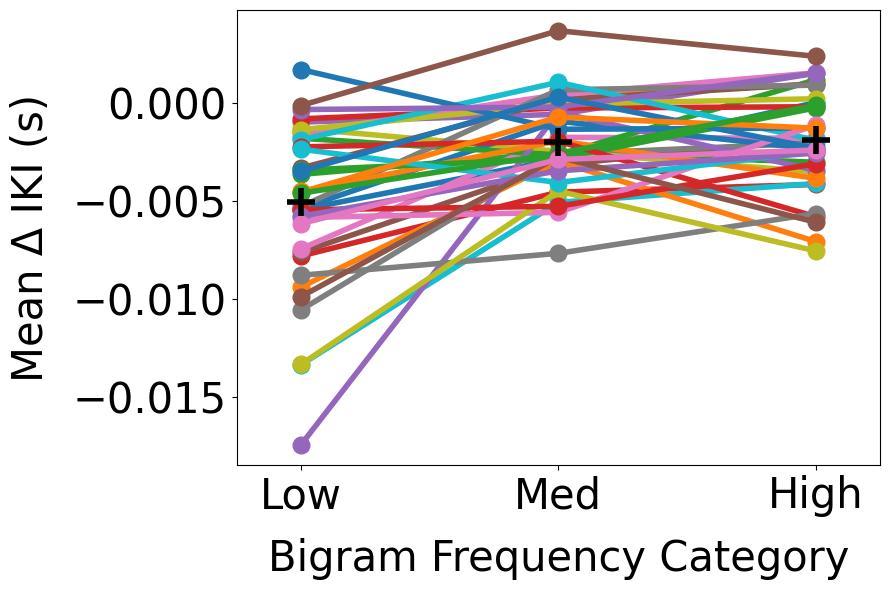

In [79]:
## plotting mean delta iki by BF group

plt.set_cmap('tab20')

x = [2, 4, 6]
D = (all_deltas_bybf[all_deltas_bybf['bf_type'] == 'low']['mean_deltaiki'],
    all_deltas_bybf[all_deltas_bybf['bf_type'] == 'med']['mean_deltaiki'],
    all_deltas_bybf[all_deltas_bybf['bf_type'] == 'high']['mean_deltaiki'])

means = (np.mean(all_deltas_bybf[all_deltas_bybf['bf_type'] == 'low']['mean_deltaiki']),
        np.mean(all_deltas_bybf[all_deltas_bybf['bf_type'] == 'med']['mean_deltaiki']),
        np.mean(all_deltas_bybf[all_deltas_bybf['bf_type'] == 'high']['mean_deltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-0.129, 0.06])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaiki_bywf.png', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

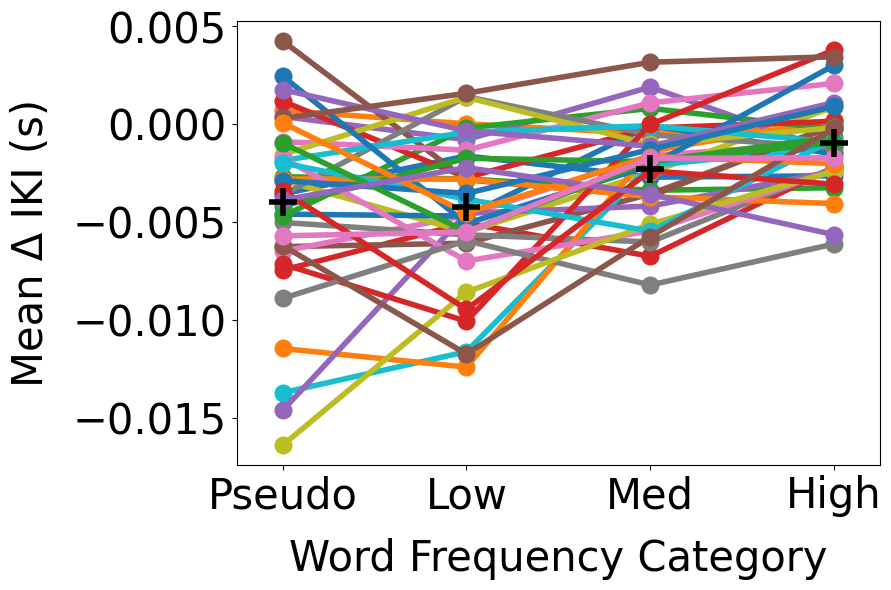

In [80]:
## plotting mean delta iki by WF group

plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (all_deltas_bywf[all_deltas_bywf['wf_type'] == 'pseudo']['mean_deltaiki'],
    all_deltas_bywf[all_deltas_bywf['wf_type'] == 'low']['mean_deltaiki'],
     all_deltas_bywf[all_deltas_bywf['wf_type'] == 'med']['mean_deltaiki'],
    all_deltas_bywf[all_deltas_bywf['wf_type'] == 'high']['mean_deltaiki'])

means = (np.mean(all_deltas_bywf[all_deltas_bywf['wf_type'] == 'pseudo']['mean_deltaiki']),
        np.mean(all_deltas_bywf[all_deltas_bywf['wf_type'] == 'low']['mean_deltaiki']),
        np.mean(all_deltas_bywf[all_deltas_bywf['wf_type'] == 'med']['mean_deltaiki']),
        np.mean(all_deltas_bywf[all_deltas_bywf['wf_type'] == 'high']['mean_deltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-0.129, 0.06])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaiki_bywf.png', dpi=300)
plt.show()

In [81]:
pseudo_strings = corr_trials_bybg[corr_trials_bybg['bf_type'] == 'high']
pseudo_ikis = pseudo_strings.groupby(['sID', 'rep_num']).IKI.agg(['mean']).reset_index()
pseudo_ikis

sID  rep_num      mean
0    s009        0  0.102294
1    s009        1  0.098216
2    s009        2  0.102301
3    s009        3  0.108112
4    s009        4  0.097995
..    ...      ...       ...
365  s311        5  0.078049
366  s311        6  0.091869
367  s311        7  0.075710
368  s311        8  0.088584
369  s311        9  0.076071

[370 rows x 3 columns]

<Figure size 640x480 with 0 Axes>

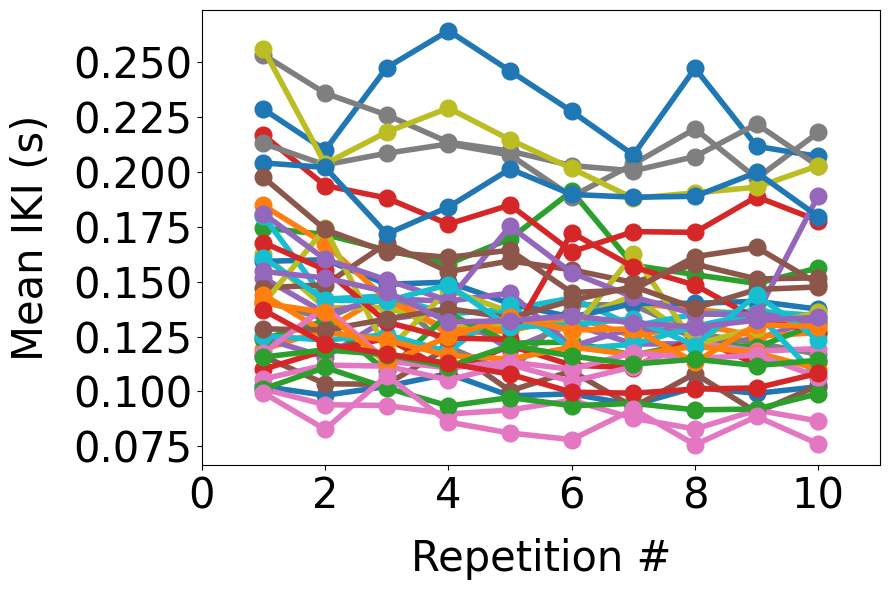

In [82]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = list(range(1,11))
D = (pseudo_ikis[pseudo_ikis['rep_num'] == 0]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 1]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 2]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 3]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 4]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 5]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 6]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 7]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 8]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 9]['mean'])

# means = (np.mean(mean_rts[mean_rts['wf_type'] == 'pseudo']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'lowwf']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'medwf']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'highwf']['key_resp.rt.1']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
# ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([0.6, 0.65])
plt.xlim([0, 11])
plt.xticks(fontsize=30)
plt.xlabel("Repetition #", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meaniki_byrep.png', dpi=300)
plt.show()

## High BF/WF IKIs vs. Simulated Null (currently skipping because it takes so long)

In [83]:
# # Calcuating mean and STD delta IKI of high freq. bigrams
# highbf_df = all_deltas_bybf[all_deltas_bybf['bf_type'] == 'high']
# highbf_mean = highbf_df.mean_deltaiki.mean()
# highbf_std = highbf_df.mean_deltaiki.std()

# # Creating dataframe of mean delta IKIs calculated from shuffled High BF 
# # datasets
# shuff_iki = null_deltas(corr_trials_bybg, 'IKI')
# shuff_highbf = shuff_iki[shuff_iki[2] == 'bf_type']

# # Saving random dataset to report
# # shuff_highbf.to_csv(save_dir + '/shuff_highbf_MMDDYYYY.csv')

# # Printing relevant information
# print('Mean delta IKI of collected high BF bigrams', 
#       highbf_mean, '±',
#       highbf_std)
# print('Average of shuffled mean delta IKIs', 
#       np.mean(shuff_highbf[3]), '±',
#       np.std(shuff_highbf[3]))
# print('estimated p-val:', np.mean(abs(shuff_highbf[3]) > abs(highbf_mean)))

# # Plotting mean delta IKIs of shuffled data and collected high freq. bigrams
# plt.hist(shuff_highbf[3], bins=20)
# plt.axvline(x=highbf_mean, color='red', linestyle='--')

# plt.xlabel("Mean delta IKI")
# plt.title("")

# plt.show()

In [84]:
# # Calcuating mean and STD delta IKI of high freq. words
# highwf_df = all_deltas_bywf[all_deltas_bywf['wf_type'] == 'high']
# highwf_mean = highwf_df.mean_deltaiki.mean()
# highwf_std = highwf_df.mean_deltaiki.std()

# # Creating dataframe of mean delta IKIs calculated from shuffled High WF 
# # datasets
# shuff_highwf = shuff_iki[shuff_iki[2] == 'wf_type']

# # Saving random dataset to report
# # shuff_highwf.to_csv(save_dir + '/shuff_highwf_MMDDYYYY.csv')

# # Printing relevant information
# print('Mean delta IKI of collected high freq. bigrams', 
#       highwf_mean, '±',
#       highwf_std)
# print('Average of shuffled mean delta IKIs', 
#       np.mean(shuff_highwf[3]), '±',
#       np.std(shuff_highwf[3]))
# print('estimated p-val:', np.mean(abs(shuff_highwf[3]) > abs(highwf_mean)))

# # Plotting mean delta IKIs of shuffled data and collected high freq. words
# plt.hist(shuff_highwf[3], bins=20)
# plt.axvline(x=highbf_mean, color='red', linestyle='--')

# plt.xlabel("Mean delta IKI")
# plt.title("")

# plt.show()

## Delta IKI across Bigram Location

In [163]:
deltaiki_byloc = corr_trials_bybg.groupby(['sID', 
                                           'bigram_loc', 
                                           'wf_type']).delta_iki.agg('mean')
deltaiki_byloc = pd.DataFrame(deltaiki_byloc).reset_index()

print(pg.rm_anova(deltaiki_byloc, 'delta_iki', 'bigram_loc', 'sID'))
pg.pairwise_tukey(deltaiki_byloc, 'delta_iki', 'bigram_loc', effsize='cohen')

       Source  ddof1  ddof2         F     p-unc       ng2       eps
0  bigram_loc      3    108  4.340799  0.006272  0.042464  0.949043


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A  B   mean(A)   mean(B)      diff       se         T   p-tukey     cohen
0  0  1 -0.002186 -0.003343  0.001157  0.00062  1.866715  0.243600  0.202487
1  0  2 -0.002186 -0.003573  0.001387  0.00062  2.237962  0.114300  0.255256
2  0  3 -0.002186 -0.002250  0.000064  0.00062  0.102631  0.999613  0.013253
3  1  2 -0.003343 -0.003573  0.000230  0.00062  0.371247  0.982525  0.039568
4  1  3 -0.003343 -0.002250 -0.001093  0.00062 -1.764084  0.291813 -0.209166
5  2  3 -0.003573 -0.002250 -0.001323  0.00062 -2.135331  0.143167 -0.269002

# Total Delta IKI

## Total Delta IKI Statistics

In [85]:
# Calculates delta IKI between first and final trial 
# (last rep IKI - first rep IKI)

def total_deltaiki(dataframe):
    DF = dataframe[dataframe['rep_num'].isin([1,9])]
    total_delta = pd.DataFrame(DF.groupby(['sID', 'string', 'bigram']).IKI.agg(['diff']))
    total_delta.fillna(0, inplace=True)
    if 'total_deltaiki' in dataframe.columns:
        dataframe.replace(dataframe['total_deltaiki'], total_delta)
    else:
        dataframe.insert(len(dataframe.columns), 'total_deltaiki', total_delta)
    last_trials = dataframe[dataframe['rep_num'] == 9]
    return last_trials

# Calculates individual mean of total delta IKI for each subject.
def indiv_totaldeltaiki(dataframe, str_or_bg, typ_group_list):
    all_means = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        if str_or_bg == 'string':
            DF = dataframe[dataframe.string.isin(group)]
        elif str_or_bg == 'bigram':
            DF = dataframe[dataframe.bigram.isin(group)]
        totaldelta_DF = total_deltaiki(DF)
        totaldelta_DF = totaldelta_DF[totaldelta_DF['rep_num'] != 0]
        deltas = totaldelta_DF.groupby(['sID', 
                                        'string', 
                                        'bigram']).total_deltaiki.agg(['mean']).reset_index()
        deltas = deltas.rename(columns={'mean': 'total_deltaiki'})
        total_deltaikis = deltas.groupby('sID').total_deltaiki.agg(['mean']).reset_index()
        total_deltaikis = total_deltaikis.rename(columns={'mean': 
                                                          'total_deltaiki'})
        if str_or_bg == 'string':
            if 'avg' in typ_group:
                freq_type = typ_group
                exclude_chars = ['avg_', 'bf']
                for char in exclude_chars:
                    freq_type = freq_type.replace(char, "")
                total_deltaikis['avgbf_type'] = freq_type
            else:
                freq_type = typ_group.replace('wf', "")
                total_deltaikis['wf_type'] = freq_type
        elif str_or_bg == 'bigram':
             freq_type = typ_group.replace('bf', "")
             total_deltaikis['bf_type'] = freq_type
        all_means = pd.concat([all_means, total_deltaikis])
    return all_means.reset_index(drop=True)

In [86]:
# indiv_totaldeltaiki(corr_trials_bybg, 'bigram', bf_groups)
# total_deltaiki(corr_trials_bybg)

In [87]:
# anova comparing total delta IKI across BF
all_totaldeltas_bybf = indiv_totaldeltaiki(corr_trials_bybg, 'bigram', bf_groups)

print(pg.rm_anova(all_totaldeltas_bybf, 'total_deltaiki', 'bf_type', 'sID'))
pg.pairwise_tukey(all_totaldeltas_bybf, 'total_deltaiki', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc       ng2      eps
0  bf_type      2     72  5.942511  0.004086  0.072286  0.62003


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low -0.008249 -0.021342  0.013093  0.004771  2.744373  0.019298   
1  high  med -0.008249 -0.010912  0.002663  0.004771  0.558124  0.842523   
2   low  med -0.021342 -0.010912 -0.010430  0.004771 -2.186249  0.078103   

      cohen  
0  0.580857  
1  0.184144  
2 -0.446352

In [88]:
# anova comparing total delta IKI across BF
all_totaldeltas_bywf = indiv_totaldeltaiki(corr_trials_bybg, 'string', wf_groups)

print(pg.rm_anova(all_totaldeltas_bywf, 'total_deltaiki', 'wf_type', 'sID'))
pg.pairwise_tukey(all_totaldeltas_bywf, 'total_deltaiki', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc      ng2      eps
0  wf_type      3    108  6.726405  0.000333  0.08617  0.86385


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.005314 -0.022868  0.017554  0.004819  3.642645  0.002108   
1  high     med -0.005314 -0.011890  0.006576  0.004819  1.364632  0.523565   
2  high  pseudo -0.005314 -0.012657  0.007343  0.004819  1.523783  0.426000   
3   low     med -0.022868 -0.011890 -0.010978  0.004819 -2.278013  0.107999   
4   low  pseudo -0.022868 -0.012657 -0.010211  0.004819 -2.118862  0.152021   
5   med  pseudo -0.011890 -0.012657  0.000767  0.004819  0.159151  0.998559   

      cohen  
0  0.893214  
1  0.379417  
2  0.319188  
3 -0.604319  
4 -0.431935  
5  0.035263

## Total Delta IKI Figures

<Figure size 640x480 with 0 Axes>

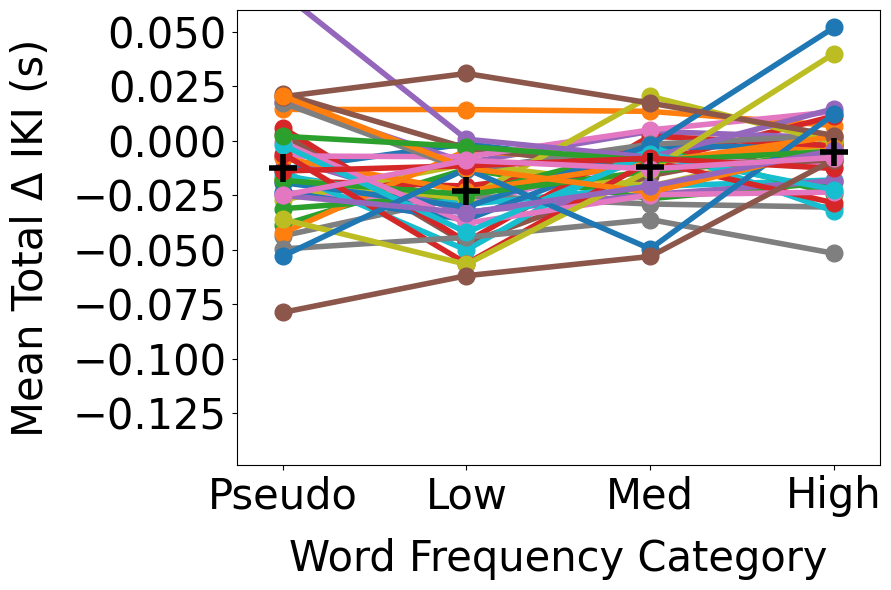

In [89]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'pseudo']['total_deltaiki'],
    all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'low']['total_deltaiki'],
    all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'med']['total_deltaiki'],
    all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'high']['total_deltaiki'])

means = (np.mean(all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'pseudo']['total_deltaiki']),
        np.mean(all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'low']['total_deltaiki']),
        np.mean(all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'med']['total_deltaiki']),
        np.mean(all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'high']['total_deltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-0.149, 0.060])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Total Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")

fig.tight_layout()
plt.savefig(save_dir + '/totaldeltaiki_bywf.png', dpi=300)
plt.show()

## Total Delta IKI across Bigram Location

In [90]:
# Comparing Mean Total Delta IKI across bigram locations
deltas = total_deltaiki(corr_trials_bybg)
total_deltaiki_byloc = deltas.groupby(['sID', 'bigram_loc']).total_deltaiki.agg('mean')
total_deltaiki_byloc = pd.DataFrame(total_deltaiki_byloc).reset_index()

print(pg.rm_anova(total_deltaiki_byloc, 'total_deltaiki', 'bigram_loc', 'sID'))
pg.pairwise_tukey(total_deltaiki_byloc, 'total_deltaiki', 'bigram_loc', effsize='cohen')

       Source  ddof1  ddof2         F     p-unc       ng2      eps
0  bigram_loc      3    108  1.233316  0.301244  0.019537  0.82577


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A  B   mean(A)   mean(B)      diff        se         T   p-tukey     cohen
0  0  1 -0.010710 -0.016248  0.005537  0.005137  1.077948  0.703524  0.231634
1  0  2 -0.010710 -0.015577  0.004867  0.005137  0.947433  0.779277  0.244990
2  0  3 -0.010710 -0.009067 -0.001643  0.005137 -0.319842  0.988639 -0.071463
3  1  2 -0.016248 -0.015577 -0.000670  0.005137 -0.130515  0.999203 -0.031684
4  1  3 -0.016248 -0.009067 -0.007180  0.005137 -1.397791  0.502790 -0.297709
5  2  3 -0.015577 -0.009067 -0.006510  0.005137 -1.267276  0.585211 -0.323528

In [161]:
# Comparing Mean Delta IKI across bigram locations
deltas = corr_trials_bybg[['sID', 'bigram_loc', 'delta_iki']].copy()
deltaiki_byloc = deltas.groupby(['sID', 'bigram_loc']).delta_iki.agg('mean')
deltaiki_byloc = pd.DataFrame(deltaiki_byloc).reset_index()

print(pg.rm_anova(deltaiki_byloc, 'delta_iki', 'bigram_loc', 'sID'))
pg.pairwise_tukey(deltaiki_byloc, 'delta_iki', 'bigram_loc', effsize='cohen')

       Source  ddof1  ddof2         F     p-unc       ng2       eps
0  bigram_loc      3    108  4.353245  0.006175  0.042411  0.953977


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A  B   mean(A)   mean(B)      diff        se         T   p-tukey     cohen
0  0  1 -0.002186 -0.003321  0.001135  0.000697  1.629164  0.365571  0.359643
1  0  2 -0.002186 -0.003568  0.001382  0.000697  1.983880  0.198866  0.457907
2  0  3 -0.002186 -0.002240  0.000055  0.000697  0.078737  0.999824  0.021481
3  1  2 -0.003321 -0.003568  0.000247  0.000697  0.354716  0.984640  0.073072
4  1  3 -0.003321 -0.002240 -0.001080  0.000697 -1.550427  0.410341 -0.363132
5  2  3 -0.003568 -0.002240 -0.001327  0.000697 -1.905143  0.230455 -0.469305

In [92]:
# # Plotting Mean Total Delta IKI across bigram locations
# diffs = deltas[deltas['rep_num'] == 9].sort_values(by=['sID', 'string'])
# indiv_diffs = pd.DataFrame(diffs.groupby(['sID', 
#                                           'bigram_loc']).total_deltaiki.agg('mean')).reset_index()

# x = (2, 4, 6, 8)
# D = (indiv_diffs.groupby(['bigram_loc']).total_deltaiki.mean())
# st_dev = (indiv_diffs.groupby(['bigram_loc']).total_deltaiki.std())

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.errorbar(x, D, st_dev, c='r')
# plt.show()

# Repetition Effects

In [93]:
# Mean IKI of first reps vs mean IKI of last reps by individual (across all categories)
rep1 = corr_trials_bybg[corr_trials_bybg['rep_num'] == 0]
rep1_meaniki = rep1.groupby('sID').IKI.agg(['mean']).reset_index(drop=True)
rep1_rt = rep1[rep1['bigram_loc'] == 0]
rep1_meanrt = rep1_rt.groupby('sID').IKI.agg(['mean']).reset_index(drop=True)

rep10 = corr_trials_bybg[corr_trials_bybg['rep_num'] == 9]
rep10_meaniki = rep10.groupby('sID').IKI.agg('mean').reset_index(drop=True)
rep10_rt = rep10[rep10['bigram_loc'] == 0]
rep10_meanrt = rep10_rt.groupby('sID').IKI.agg(['mean']).reset_index(drop=True)

print('mean IKI:')
print(pg.ttest(rep1_meaniki['mean'], rep10_meaniki, paired=True))
print('mean RT:')
print(pg.ttest(rep1_meanrt['mean'], rep10_meanrt['mean'], paired=True))

mean IKI:
               T  dof alternative         p-val         CI95%   cohen-d  \
T-test  6.130665   36   two-sided  4.650843e-07  [0.01, 0.03]  0.533208   

             BF10     power  
T-test  3.514e+04  0.884105  
mean RT:
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  3.957464   36   two-sided  0.000341  [0.01, 0.03]  0.337959  81.69   

           power  
T-test  0.516301  


In [94]:
# ## plotting overall bg repetition effect
# plt.rcParams.update(plt.rcParamsDefault)
# # plt.style.use('fast')
# plt.set_cmap('tab20')

# x = ('first_rep', 'last_rep')
# D = (rep1_meaniki.mean.mean(), rep10_meaniki.mean.mean())
# sds = (rep1_meaniki.mean.std(), rep10_meaniki.mean.std())

# plt.bar(x, D, color = 'deepskyblue', width = 0.4)
# plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

# plt.show()

In [95]:
## repetition effect of high freq bgs
highbf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['bf_type'] == 'high')].reset_index()
highbf_firstrep = highbf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
highbf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['bf_type'] == 'high')].reset_index()
highbf_lastrep = highbf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

highbf_diffs = (highbf_lastrep.IKI - highbf_firstrep.IKI)

## repetition effect of low freq bgs
lowbf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['bf_type'] == 'low')].reset_index()
lowbf_firstrep = lowbf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
lowbf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['bf_type'] == 'low')].reset_index()
lowbf_lastrep = lowbf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

lowbf_diffs = (lowbf_lastrep.IKI - lowbf_firstrep.IKI)

pg.ttest(highbf_diffs, lowbf_diffs)
highbf_lastrep

index   sID  bigram_num  trial_num  rep_num  bigram_loc bigram  \
9       840  s009         840        210        9           2     ou   
12      883  s009         883        221        9           1     ha   
7       831  s009         831        208        9           1     he   
8       833  s009         833        208        9           3     er   
11      881  s009         881        220        9           3     ed   
...     ...   ...         ...        ...      ...         ...    ...   
1079  22989  s311         891        220        9           1     it   
1080  22990  s311         892        220        9           2     th   
1081  22991  s311         893        220        9           3     he   
1087  23038  s311         940        232        9           1     an   
1083  22997  s311         899        222        9           1     ou   

     resp_bigram       IKI string resp_string     bg_freq bf_type meanbf_type  \
9             ou  0.055787  about       about   7425307.0    high         med   
12            ha  0.111921  champ       champ   6967591.0    high         med   
7             he  0.135950  cheer       cheer  21484684.0    high        high   
8             er  0.095798  cheer       cheer  12934901.0    high        high   
11            ed  0.192099  cooed       cooed   7805967.0    high         med   
...          ...       ...    ...         ...         ...     ...         ...   
1079          it  0.104231  tithe       tithe   6637233.0    high        high   
1080          th  0.024058  tithe       tithe  22288309.0    high        high   
1081          he  0.103990  tithe       tithe  21484684.0    high        high   
1087          an  0.071766  vanru       vanru  12315713.0    high         med   
1083          ou  0.063787  would       would   7425307.0    high         med   

     wf_type  trial_corr  bg_corr  delta_iki  total_deltaiki  
9       high        True     True   0.023970       -0.007968  
12       med        True     True   0.015955       -0.008173  
7        med        True     True   0.015982       -0.000108  
8        med        True     True   0.039873        0.007967  
11       low        True     True   0.008206        0.024044  
...      ...         ...      ...        ...             ...  
1079     low        True     True   0.008281       -0.007749  
1080     low        True     True   0.008022       -0.048459  
1081     low        True     True  -0.055803        0.008405  
1087  pseudo        True     True  -0.080227       -0.024222  
1083    high        True     True   0.007810       -0.016204  

[1098 rows x 19 columns]

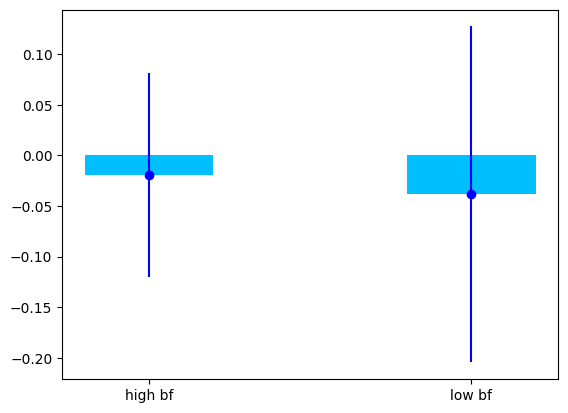

In [96]:
## plotting repetition effect on high vs low freq bgs
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = ('high bf', 'low bf')
D = (highbf_diffs.mean(), lowbf_diffs.mean())
sds = (highbf_diffs.std(), lowbf_diffs.std())

plt.bar(x, D, color = 'deepskyblue', width = 0.4)
plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

plt.show()

In [97]:
## repetition effect of high freq wfs
highwf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['wf_type'] == 'high')].reset_index()
highwf_firstrep = highwf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
highwf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['wf_type'] == 'high')].reset_index()
highwf_lastrep = highwf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

highwf_diffs = (highwf_lastrep.IKI - highwf_firstrep.IKI).reset_index(drop=True)

## repetition effect of low freq wfs
lowwf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['wf_type'] == 'low')].reset_index()
lowwf_firstrep = lowwf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
lowwf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['wf_type'] == 'low')].reset_index()
lowwf_lastrep = lowwf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

lowwf_diffs = (lowwf_lastrep.IKI - lowwf_firstrep.IKI).reset_index(drop=True)

pg.ttest(highwf_diffs, lowwf_diffs)

T          dof alternative     p-val        CI95%   cohen-d  \
T-test  2.722788  1367.246734   two-sided  0.006556  [0.0, 0.03]  0.137168   

         BF10     power  
T-test  2.196  0.781704

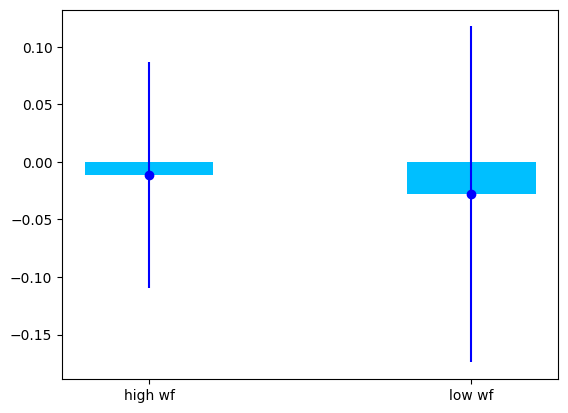

In [98]:
## plotting repetition effect on high vs low freq wfs
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = ('high wf', 'low wf')
D = (highwf_diffs.mean(), lowwf_diffs.mean())
sds = (highwf_diffs.std(), lowwf_diffs.std())

plt.bar(x, D, color = 'deepskyblue', width = 0.4)
plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

plt.show()

In [99]:
# x = [(2, 4, 6, 8), (2, 4, 6, 8)]
# D = [first_reps.groupby('bigram_loc').IKI.mean(),
#      last_reps.groupby('bigram_loc').IKI.mean()]
# st_dev = [first_reps.groupby('bigram_loc').IKI.std(),
#           last_reps.groupby('bigram_loc').IKI.std()]

# fig, ax = plt.subplots(figsize=(9, 6))
# # ax.plot(x, D, '.-', linewidth=4, ms=24)
# plt.errorbar(x[0], D[0], st_dev[0], c='r')
# plt.errorbar(x[1], D[1], st_dev[1], c='b')

# plt.show()

# Individual Differences

## Sensitivity to individual differences

In [100]:
## calculating senstivity to individual differences (with weird metric I made up)
# D = pd.concat([indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf'), 
#      indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf'),
#      indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')])

# high_bf

# np.mean(choose2(D['Avg IKI'], operation = abs_difference))
perms = list(it.permutations(indiv_sdikis(corr_trials_bybg, 'bigram', 'medbf')['Avg SD IKI'], 2))
# for x in perms:
#     abs(x[1] - x[2])

sample_diffs = [abs(x[0] - x[1]) for x in perms]
indiv_sens = np.mean(sample_diffs)/np.mean(indiv_sdikis(corr_trials_bybg, 'bigram', 'medbf')['Avg SD IKI'])
indiv_sens

0.3959456902843304

In [101]:
# Runs pearson correlation across for a given metric across all bigram/word 
# frequency category permutations.
def metric_corr(dataframe, metric):
    if 'bf_type' in dataframe.columns:
        freq_type = 'bf_type'
        freq_types = ['low', 'med', 'high']
    elif 'wf_type' in dataframe.columns:
        freq_type = 'wf_type'
        freq_types = ['pseudo', 'low', 'med', 'high']
    no_bon = []
    for freq1 in freq_types:
        for freq2 in freq_types:
            pearson = pearsonr(dataframe[dataframe[freq_type] == freq1][metric], 
                              dataframe[dataframe[freq_type] == freq2][metric])
            no_bon.append([freq1, freq2, pearson[0], pearson[1]])
    comp_vals = pd.DataFrame(no_bon).rename(columns={0: 'freq1', 
                                                     1: 'freq2',
                                                     2: 'r_stat',
                                                     3: 'no_bon_pval'})
    no_bon_pvals = comp_vals['no_bon_pval']
    comp_vals['bon_pvals'] = [p*len(no_bon_pvals) for p in no_bon_pvals]
    comp_vals['freq_type'] = f"{freq_type}"
    comp_vals['metric'] = f"{metric}"
    return comp_vals

# Calculates all correlations for a given set of frequency types and metrics.
def combine_corrs(df_list, metric_list):
    all_corrs = pd.DataFrame()
    for dataframe in df_list:
        for metric in metric_list:
            one_corr = metric_corr(dataframe, metric)
            all_corrs = pd.concat([all_corrs, one_corr])
    return all_corrs.reset_index(drop=True)

In [102]:
# Calculates pearson correlations for Mean, SD, and CV IKI across all bigram and
# word frequencies.
df_list = [all_bybf, all_bywf]
metric_list = ['mean_IKI', 'sd_IKI', 'cv_IKI']

combine_corrs(df_list, metric_list)

freq1   freq2    r_stat   no_bon_pval     bon_pvals freq_type    metric
0    low     low  1.000000  0.000000e+00  0.000000e+00   bf_type  mean_IKI
1    low     med  0.932050  5.299462e-17  4.769516e-16   bf_type  mean_IKI
2    low    high  0.873767  1.678415e-12  1.510573e-11   bf_type  mean_IKI
3    med     low  0.932050  5.299462e-17  4.769516e-16   bf_type  mean_IKI
4    med     med  1.000000  0.000000e+00  0.000000e+00   bf_type  mean_IKI
..   ...     ...       ...           ...           ...       ...       ...
70   med    high  0.431749  7.624121e-03  1.219859e-01   wf_type    cv_IKI
71  high  pseudo  0.371121  2.373457e-02  3.797531e-01   wf_type    cv_IKI
72  high     low  0.310003  6.186699e-02  9.898719e-01   wf_type    cv_IKI
73  high     med  0.431749  7.624121e-03  1.219859e-01   wf_type    cv_IKI
74  high    high  1.000000  0.000000e+00  0.000000e+00   wf_type    cv_IKI

[75 rows x 7 columns]

In [103]:
# Calculating pearson correlations
# pcorr_mean_bf = metric_corr(all_bybf, 'bf_type', 'mean_IKI')

# # Load converting data to long form
# heat_mean_bf = (
#     pcorr_mean_wf
#     .pivot(index="freq1", columns="freq2", values="r_stat")
# )

# heat_mean_bf = heat_mean_bf.reindex(columns=['pseudo', 'low', 'med', 'high'],
#                                     index=['high', 'med', 'low', 'pseudo'])

# # Draw a heatmap with the numeric values in each cell
# f, ax = plt.subplots(figsize=(9, 6))
# sns.heatmap(heat_mean_bf, annot=True, cmap='flare', linewidths=.5, ax=ax)
# plt.show()

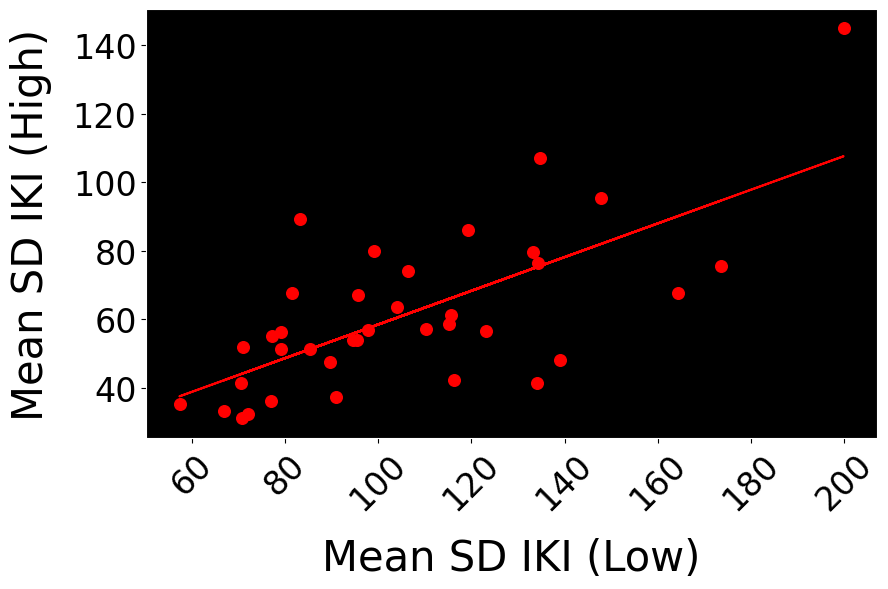

In [104]:
##plotting sd correlation
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI'], 
            all_bybf[all_bybf['bf_type'] == 'high']['sd_IKI'], 
            s = 70, color = 'red')

z = np.polyfit(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI'], 
               all_bybf[all_bybf['bf_type'] == 'high']['sd_IKI'], 1)
p = np.poly1d(z)
plt.plot(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI'],
         p(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI']),
         color = 'red')

plt.xlabel("Mean SD IKI (Low)", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI (High)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
# plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'SD_correlation_bysub', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

## Individual metrics across all bigrams/trials for Turbo analysis

In [105]:
# Calcuating individual metrics across all trials/bigrams
iki_global = indiv_ikimetric(corr_trials_bybg, 'string', no_groups, iki_metrics)
rt_global = indiv_rtmetric(corr_trials, no_groups, iki_metrics)
deltaiki_global = indiv_meandeltaiki(corr_trials_bybg, 'string', no_groups)
totaldeltaiki_global = indiv_totaldeltaiki(corr_trials_bybg, 'string', no_groups)
deltart_global = indiv_deltart(corr_trials, no_groups)
error_global = all_ikimetric(indiv_error, incorr_bgs, 'string', no_groups)

# Concetenating into one dataframe and exporting to .csv.
indiv_globalmetrics = pd.concat([iki_global,
                                 rt_global,
                                 deltaiki_global,
                                 totaldeltaiki_global,
                                 deltart_global,
                                 error_global], axis = 1)
indiv_globalmetrics = indiv_globalmetrics.loc[:, ~indiv_globalmetrics.columns.duplicated()]
indiv_globalmetrics = indiv_globalmetrics.drop(['wf_type', 'index'], axis = 1)

indiv_globalmetrics.to_csv(save_dir + '/indiv_globalmetrics.csv')

# Paper Figures

## Fig. 1

In [106]:
# Melting IKI data into correct format
# for freq_type in freq_types:
    
bybf_melted = all_bybf.melt(id_vars=['sID', 'bf_type'],
                            value_vars=['mean_IKI', 'sd_IKI', 'cv_IKI'],
                            var_name='IKI_metric',
                            value_name='value')
bybf_melted['freq_type'] = 'bf_type'
bybf_melted = bybf_melted.rename(columns={'bf_type':'freq'})

bywf_melted = all_bywf.melt(id_vars=['sID', 'wf_type'],
                            value_vars=['mean_IKI', 'sd_IKI', 'cv_IKI'],
                            var_name='IKI_metric',
                            value_name='value')
bywf_melted['freq_type'] = 'wf_type'
bywf_melted = bywf_melted.rename(columns={'wf_type':'freq'})

graph_data = pd.concat([bybf_melted, bywf_melted])

# Melting RT data into correct format
rtbf_melted = rt_bywf.melt(id_vars=['sID', 'wf_type'],
                            value_vars=['mean_RT', 'sd_RT', 'cv_RT'],
                            var_name='IKI_metric',
                            value_name='value')

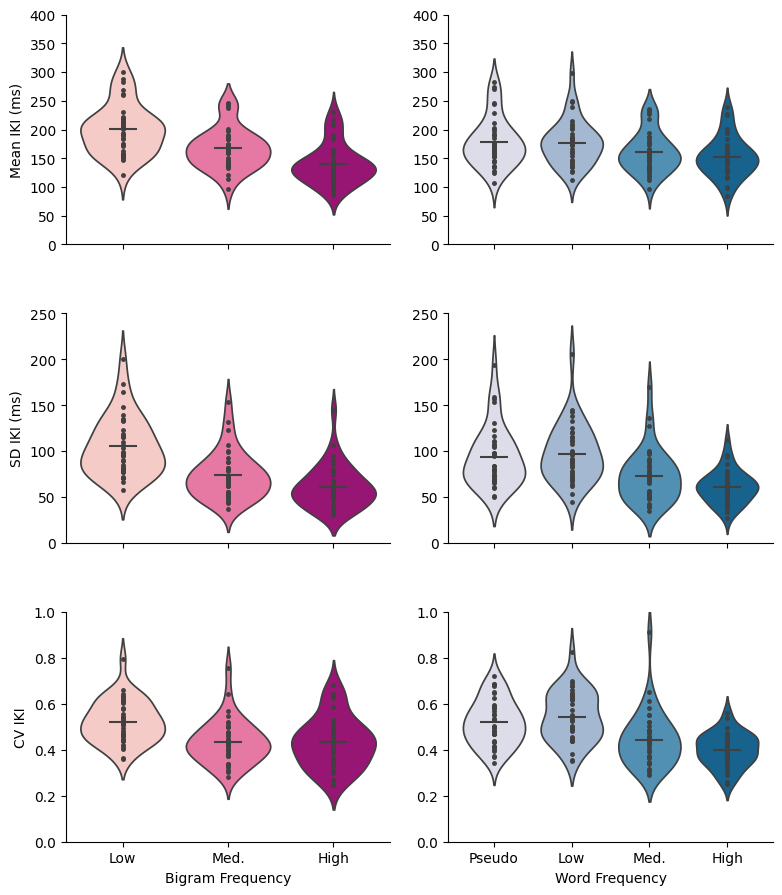

In [239]:
# Fig. 1a - Mean, SD, CV IKI for BF and WF categories

# Making palette and hue dictionaries
palette_dict = {'bf_type': 'RdPu', 'wf_type': 'PuBu'}
hue_order_dict = {'bf_type': ['low', 'med', 'high'],
                  'wf_type': ['pseudo', 'low', 'med', 'high']}

# Making facetgrid
g = sns.FacetGrid(graph_data, 
                  col='freq_type', 
                  row='IKI_metric', 
                  hue='freq',
                  sharey=False,
                  sharex=False,
                  height=3,
                  aspect=1.3)

# Making each column use a different color palette
for (bf_or_wf, ax) in g.axes_dict.items():
    palette = palette_dict[bf_or_wf[1]]
    hue_order = hue_order_dict[bf_or_wf[1]]
    data = graph_data[(graph_data['freq_type'] == bf_or_wf[1]) 
                    & (graph_data['IKI_metric'] == bf_or_wf[0])]
    sns.violinplot(data, 
                   x='freq', 
                   y='value', 
                   hue='freq', 
                   hue_order=hue_order, 
                   palette=palette, 
                   ax=ax,
                   edgecolor='0.25',
                   inner='point',
                   inner_kws=dict(edgecolor='0.25', color=".25"))
    violin_means = data.groupby(['freq_type', 
                                 'freq']).value.agg('mean').reset_index()
    if bf_or_wf[1] == 'bf_type':
        categories = ['low', 'med', 'high']
    elif bf_or_wf[1] == 'wf_type':
        categories = ['pseudo', 'low', 'med', 'high']
    violin_means['freq'] = pd.Categorical(violin_means['freq'],
                                              categories=categories,
                                              ordered=True)                          
    violin_means = violin_means.sort_values(by="freq")
    sns.scatterplot(x=range(len(violin_means['value'])), y=violin_means['value'], 
                    color='0.25', ax=ax,
                    marker='_', linewidth=1.5, s=400)

    
# Getting rid of facet titles
g.set_titles(template="")

# Setting y-axis limits for respective rows
g.axes[0, 0].set_ylim(0, 400)
g.axes[1, 0].set_ylim(0, 250)
g.axes[2, 0].set_ylim(0, 1)
g.axes[0, 1].set_ylim(0, 400)
g.axes[1, 1].set_ylim(0, 250)
g.axes[2, 1].set_ylim(0, 1)

# Setting y-labels
g.axes[0, 0].set_ylabel('Mean IKI (ms)')
g.axes[1, 0].set_ylabel('SD IKI (ms)')
g.axes[2, 0].set_ylabel('CV IKI')
g.axes[0, 1].set_ylabel('')
g.axes[1, 1].set_ylabel('')
g.axes[2, 1].set_ylabel('')

# Setting x-labels
g.axes[0, 0].set_xlabel('')
g.axes[1, 0].set_xlabel('')
g.axes[2, 0].set_xlabel('Bigram Frequency')
g.axes[0, 1].set_xlabel('')
g.axes[1, 1].set_xlabel('')
g.axes[2, 1].set_xlabel('Word Frequency')

# Setting x-ticks and labels
g.axes[0, 0].set_xticks([0, 1, 2], ['', '', ''])
g.axes[1, 0].set_xticks([0, 1, 2], ['', '', ''])
g.axes[2, 0].set_xticks([0, 1, 2], ['Low', 'Med.', 'High'])
g.axes[0, 1].set_xticks([0, 1, 2, 3], ['', '', '', ''])
g.axes[1, 1].set_xticks([0, 1, 2, 3], ['', '', '', ''])
g.axes[2, 1].set_xticks([0, 1, 2, 3], ['Pseudo', 'Low', 'Med.', 'High'])

# Adjusting horizontal space between subplots
plt.subplots_adjust(hspace=0.3)

plt.show()
g.savefig(save_dir + 'fig_1a.png', dpi=300)

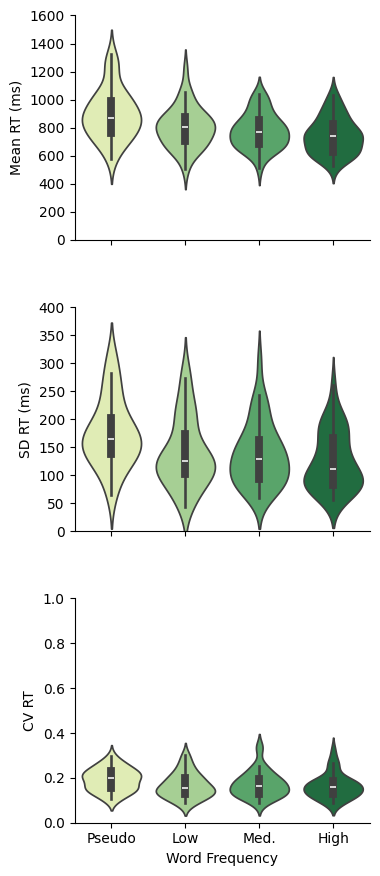

In [108]:
# Fig. 1b - Mean, SD, CV RT for WF categories
g = sns.FacetGrid(rtbf_melted,  
                  row='IKI_metric', 
                  hue='wf_type',
                  palette='YlGn',
                  sharey=False,
                  sharex=False,
                  height=3,
                  aspect=1.3)

g.map(sns.violinplot, 
      'wf_type',              
      'value',               
      order=['pseudo', 'low', 'med', 'high'],
      edgecolor='.25',
      inner = 'point',
      inner_kws=dict(edgecolor='0.25', color=".25"))
    
# Getting rid of facet titles
g.set_titles(template="")

# Setting y-axis limits for respective rows
g.axes[0, 0].set_ylim(0, 1600)
g.axes[1, 0].set_ylim(0, 400)
g.axes[2, 0].set_ylim(0, 1)

# Setting y-labels
g.axes[0, 0].set_ylabel('Mean RT (ms)')
g.axes[1, 0].set_ylabel('SD RT (ms)')
g.axes[2, 0].set_ylabel('CV RT')

# Setting x-labels
g.axes[0, 0].set_xlabel('')
g.axes[1, 0].set_xlabel('')
g.axes[2, 0].set_xlabel('Word Frequency')

# Setting x-ticks and labels
g.axes[0, 0].set_xticks([0, 1, 2, 3], ['', '', '', ''])
g.axes[1, 0].set_xticks([0, 1, 2, 3], ['', '', '', ''])
g.axes[2, 0].set_xticks([0, 1, 2, 3], ['Pseudo', 'Low', 'Med.', 'High'])

# Adjusting horizontal space between subplots
plt.subplots_adjust(hspace=0.3)

plt.show()
g.savefig(save_dir + 'fig_1b.png', dpi=300)

## Fig. 2

In [109]:
# Formatting error data into correct format
all_errors_bybf['freq_type'] = 'bf_type'
all_errors_bybf = all_errors_bybf.rename(columns={'bf_type':'freq'})

all_errors_bywf['freq_type'] = 'wf_type'
all_errors_bywf = all_errors_bywf.rename(columns={'wf_type':'freq'})

fig2_data = pd.concat([all_errors_bybf, all_errors_bywf])

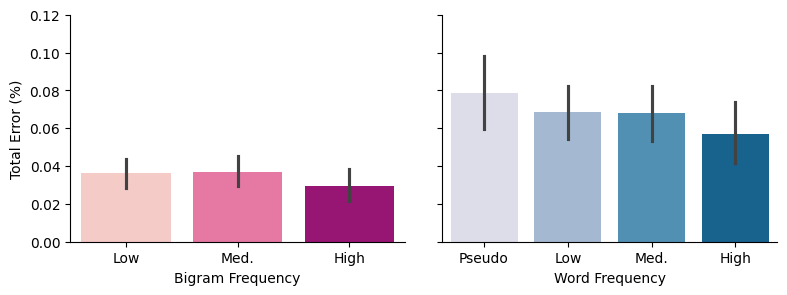

In [110]:
# Fig. 2 - Total Error count for BF and WF categories

# Making palette and hue dictionaries
palette_dict = {'bf_type': 'RdPu', 'wf_type': 'PuBu'}
hue_order_dict = {'bf_type': ['low', 'med', 'high'],
                  'wf_type': ['pseudo', 'low', 'med', 'high']}

# Making facetgrid
g = sns.FacetGrid(fig2_data, 
                  col='freq_type',
                  sharey=True,
                  sharex=False,
                  height=3,
                  aspect=1.3)

# Making each column use a different color palette
for (bf_or_wf, ax) in g.axes_dict.items():
    palette = palette_dict[bf_or_wf]
    hue_order = hue_order_dict[bf_or_wf]
    sns.barplot(data=fig2_data[(fig2_data['freq_type'] == bf_or_wf)], 
                   x='freq', 
                   y='relative_error', 
                   hue='freq', 
                   hue_order=hue_order, 
                   palette=palette, 
                   ax=ax)
                   # edgecolor='0.25')
    
# Getting rid of facet titles
g.set_titles(template="")

# Setting y-axis limits for respective rows
g.axes[0, 0].set_ylim(0, 0.12)
g.axes[0, 1].set_ylim(0, 0.12)

# Setting y-labels
g.axes[0, 0].set_ylabel('Total Error (%)')
g.axes[0, 1].set_ylabel('')

# Setting x-labels
g.axes[0, 0].set_xlabel('Bigram Frequency')
g.axes[0, 1].set_xlabel('Word Frequency')

# Setting x-ticks and labels
g.axes[0, 0].set_xticks([0, 1, 2], ['Low', 'Med.', 'High'])
g.axes[0, 1].set_xticks([0, 1, 2, 3], ['Pseudo', 'Low', 'Med.', 'High'])

plt.show()
g.savefig(save_dir + 'fig_2.png', dpi=300)

## Fig. 3

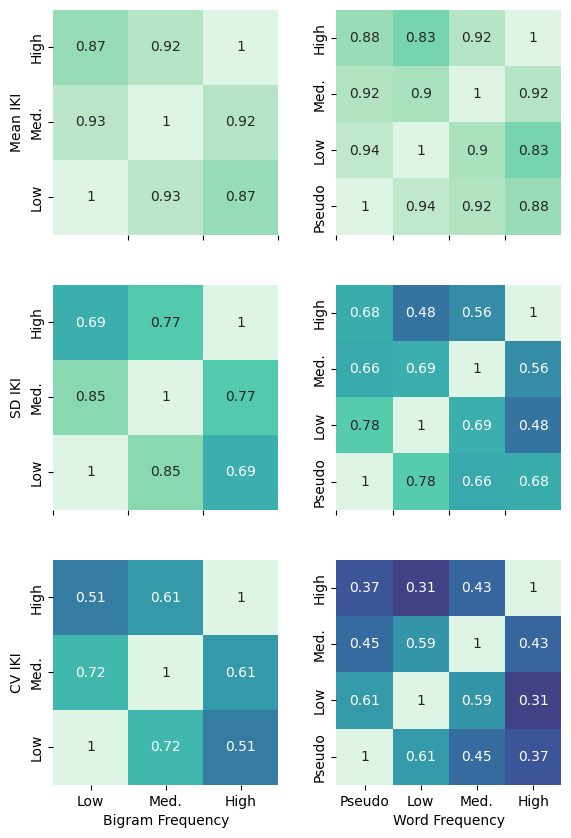

In [111]:
# Fig. 3a - Pearson correlation r-statistics for Mean, SD, and CV IKI

# Setting data variable
all_heat_data = combine_corrs(df_list, metric_list)

# Function to produce heatmaps based on data for a given frequency type and 
# metric of interest.
def draw_heatmap(data, **kwargs):
    heat_data = (data.pivot(index="freq1", columns="freq2", values="r_stat"))
    cols = heat_data.columns.unique().tolist()
    if 'pseudo' in cols:
        heat_data = heat_data.reindex(columns=['pseudo', 'low', 
                                               'med', 'high'],
                                      index=['high', 'med', 
                                             'low', 'pseudo'])
    else: 
        heat_data = heat_data.reindex(columns=['low', 'med', 'high'],
                                      index=['high', 'med', 'low'])
    sns.heatmap(heat_data, square=True, cbar=False, **kwargs)

# Creates facet grid for heat maps.
g = sns.FacetGrid(all_heat_data, 
                  col='freq_type', 
                  row='metric',
                  margin_titles=True,
                  sharex=False,
                  sharey=False)

# Plots heatmaps
g.map_dataframe(draw_heatmap, cmap='mako', annot=True, vmin=0, vmax=1)

# Getting rid of facet titles
g.set_titles(col_template="", row_template="")

# Setting y-labels
g.axes[0, 0].set_ylabel('Mean IKI')
g.axes[1, 0].set_ylabel('SD IKI')
g.axes[2, 0].set_ylabel('CV IKI')
g.axes[0, 1].set_ylabel('')
g.axes[1, 1].set_ylabel('')
g.axes[2, 1].set_ylabel('')

# Setting x-labels
g.axes[0, 0].set_xlabel('')
g.axes[1, 0].set_xlabel('')
g.axes[2, 0].set_xlabel('Bigram Frequency')
g.axes[0, 1].set_xlabel('')
g.axes[1, 1].set_xlabel('')
g.axes[2, 1].set_xlabel('Word Frequency')

# Setting x-ticks and labels
g.axes[0, 0].set_xticks([1, 2, 3], ['', '', ''])
g.axes[1, 0].set_xticks([0, 1, 2], ['', '', ''])
g.axes[2, 0].set_xticks([0.5, 1.5, 2.5], ['Low', 'Med.', 'High'])
g.axes[0, 1].set_xticks([0, 1, 2, 3], ['', '', '', ''])
g.axes[1, 1].set_xticks([0, 1, 2, 3], ['', '', '', ''])
g.axes[2, 1].set_xticks([0.5, 1.5, 2.5, 3.5], ['Pseudo', 'Low', 'Med.', 'High'])

# Setting y-ticks and labels
g.axes[0, 0].set_yticks([0.5, 1.5, 2.5], ['High', 'Med.', 'Low'])
g.axes[1, 0].set_yticks([0.5, 1.5, 2.5], ['High', 'Med.', 'Low'])
g.axes[2, 0].set_yticks([0.5, 1.5, 2.5], ['High', 'Med.', 'Low'])
g.axes[0, 1].set_yticks([0.5, 1.5, 2.5, 3.5], ['High', 'Med.', 'Low', 'Pseudo'])
g.axes[1, 1].set_yticks([0.5, 1.5, 2.5, 3.5], ['High', 'Med.', 'Low', 'Pseudo'])
g.axes[2, 1].set_yticks([0.5, 1.5, 2.5, 3.5], ['High', 'Med.', 'Low', 'Pseudo'])

# Adjusting space between subplots
plt.subplots_adjust(hspace=0.01)

plt.show()
g.savefig(save_dir + 'fig_3.png', dpi=300)

## Fig. 4

In [112]:
test = corr_trials[['sID', 'wf_type', 'RT', 'rep_num']].copy()
test['freq_type'] = 'wf_type'
test2 = corr_trials_bybg[['sID', 'wf_type', 'IKI', 'rep_num']].copy()
test2['freq_type'] = 'wf_type'
test3 = corr_trials_bybg[['sID', 'bf_type', 'IKI', 'rep_num']].copy()
test3['freq_type'] = 'bf_type'

full_test = pd.concat([test, test2, test3])
full_test['freq'] = full_test['wf_type'].fillna(full_test['bf_type'])

full_test

test_melted = full_test.melt(id_vars=['sID', 'freq_type', 'freq', 'rep_num'],
                            value_vars=['RT', 'IKI'],
                            var_name='metric',
                            value_name='value')

# test_melted = test_melted.dropna()
# test_melted

# # full_test[full_test['value'].isna()]
# # full_test[(full_test['IKI'].isna())]
# test_melted[test_melted['value'].isna()]

In [113]:

# palette_dict = {('RT', 'wf_type'): 'YlGn',
#                 ('RT', 'bf_type'): 'YlGn',
#                 ('IKI', 'wf_type'): 'PuBu',
#                 ('IKI', 'bf_type'): 'RdPu'}

# hue_order_dict = {'bf_type': ['low', 'med', 'high'],
#                   'wf_type': ['pseudo', 'low', 'med', 'high']}
                
# g = sns.FacetGrid(test_melted, 
#                   col='freq_type', 
#                   row='metric', 
#                   hue='freq',
#                   sharey=False,
#                   sharex=False,
#                   height=3,
#                   aspect=1.3)

# for (bf_or_wf, ax) in g.axes_dict.items():
#     print(bf_or_wf)
#     palette = palette_dict[bf_or_wf]
#     print(palette)
#     hue_order = hue_order_dict[bf_or_wf[1]]
#     data = test_melted[(test_melted['freq_type'] == bf_or_wf[1]) 
#                     & (test_melted['metric'] == bf_or_wf[0])]
#     sns.pointplot(data=test_melted,
#                   x="rep_num", 
#                   y="value", 
#                   hue="freq",
#                   hue_order=hue_order,
#                   errorbar="sd", 
#                   palette=palette, 
#                   alpha=1,
#                  ax=ax)

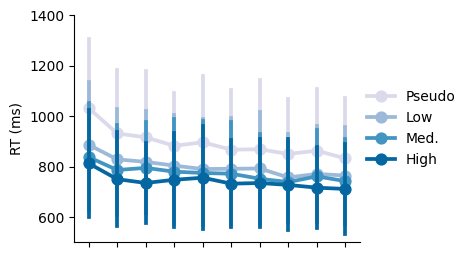

In [114]:
fig3_data = corr_trials.copy()
fig3_data['RT'] = fig3_data['RT']*1000


g = sns.catplot(
    data=fig3_data, kind="point",
    x="rep_num", y="RT", hue="wf_type",
    hue_order=('pseudo', 'lowwf', 'medwf', 'highwf'),
    errorbar="sd", palette="PuBu", alpha=1, height=3,
    aspect=1.3
)

# Setting axis labels
g.set_axis_labels("", "RT (ms)")
plt.xticks(visible=False)

# Setting ylim
plt.ylim(500, 1400)

# Modifying legend labels
g.legend.set_title("")
g._legend.texts[0].set_text('Pseudo')
g._legend.texts[1].set_text('Low')
g._legend.texts[2].set_text('Med.')
g._legend.texts[3].set_text('High')

plt.show()
g.savefig(save_dir + 'fig_4a.png', dpi=300)

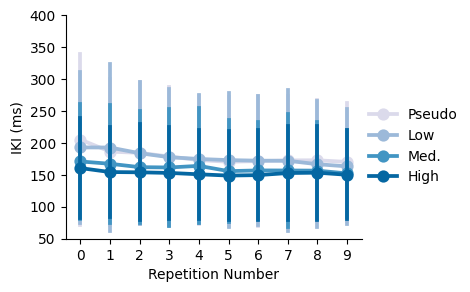

In [115]:
fig3b_data = corr_trials_bybg.copy()
fig3b_data['IKI'] = fig3b_data['IKI']*1000


g = sns.catplot(
    data=fig3b_data, kind="point",
    x="rep_num", y="IKI", hue="wf_type",
    hue_order=('pseudo', 'low', 'med', 'high'),
    errorbar="sd", palette="PuBu", alpha=1, height=3,
    aspect=1.3
)

# Setting axis labels
g.set_axis_labels("Repetition Number", "IKI (ms)")

# Setting ylim
plt.ylim(50, 400)

# Modifying legend labels
g.legend.set_title("")
g._legend.texts[0].set_text('Pseudo')
g._legend.texts[1].set_text('Low')
g._legend.texts[2].set_text('Med.')
g._legend.texts[3].set_text('High')

plt.show()
g.savefig(save_dir + 'fig_4b1.png', dpi=300)

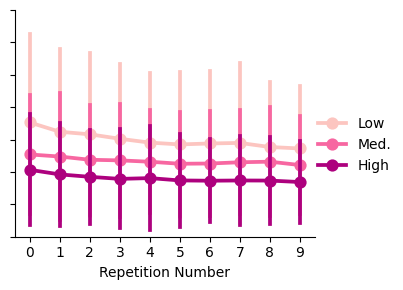

In [116]:
g = sns.catplot(
    data=fig3b_data, kind="point",
    x="rep_num", y="IKI", hue="bf_type",
    hue_order=('low', 'med', 'high'),
    errorbar="sd", palette="RdPu", alpha=1, height=3,
    aspect=1.3
)

# Setting axis labels
g.set_axis_labels("Repetition Number", "")
plt.yticks(visible=False)

# Setting ylim
plt.ylim(50, 400)

# Modifying legend labels
g.legend.set_title("")
g._legend.texts[0].set_text('Low')
g._legend.texts[1].set_text('Med.')
g._legend.texts[2].set_text('High')

plt.show()
g.savefig(save_dir + 'fig_4b2.png', dpi=300)

## Fig. 5

In [176]:
color = sns.color_palette('RdPu')[4]
print(color)
color

(0.735840061514802, 0.06196078431372548, 0.5225682429834679)


(0.735840061514802, 0.06196078431372548, 0.5225682429834679)

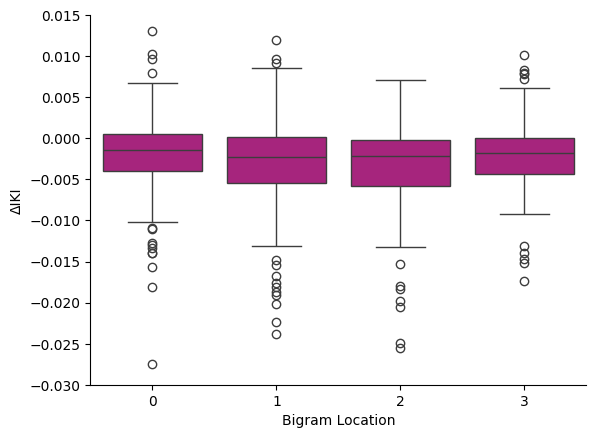

In [187]:
# Fig. 5 - delta IKI vs. bigram position
g = sns.boxplot(deltaiki_byloc, 
                   x='bigram_loc', 
                   y='delta_iki',
                   color=(0.735840061514802, 0.06196078431372548, 0.5225682429834679))
                   # edgecolor='0.25',
                   # inner='point')

sns.despine()

g.set_xlabel('Bigram Location')
g.set_ylabel('ΔIKI')

plt.ylim(-0.03, 0.015)

plt.show()
g.figure.savefig(save_dir + 'fig_5.png', dpi=300)

In [ ]:
sns.violinplot(, 
                   x='freq', 
                   y='value', 
                   hue='freq', 
                   hue_order=hue_order, 
                   palette=palette, 
                   ax=ax,
                   edgecolor='0.25',
                   inner='point')

# Paper Tables

In [117]:
# Makes table of all individual speed and variability IKI metrics
all_ikimetrics = pd.concat([all_bybf, 
                            all_bywf,
                            all_deltas_bybf,
                            all_deltas_bywf,
                            all_totaldeltas_bybf,
                            all_errors_bybf,
                            all_errors_bywf,
                            all_totaldeltas_bywf,
                            rt_bywf,
                            all_deltarts_bywf]).reset_index(drop=True)

# Calculates frequency category means and SDs and collects into dataframe
table_dict = {}

for freq_type in ['wf_type', 'bf_type']:
    for freq in all_ikimetrics[freq_type].unique():
        if pd.isna(freq) == False:
            col_list = ['mean_IKI', 'sd_IKI', 'cv_IKI',
                        'mean_deltaiki',
                        'total_error',
                        'mean_RT', 'sd_RT', 'cv_RT',
                        'mean_deltart']
            value_list = []
            for col in col_list:
                metric_mean = all_ikimetrics[all_ikimetrics[freq_type] == freq][col].mean(numeric_only=True)
                metric_sd = all_ikimetrics[all_ikimetrics[freq_type] == freq][col].std(numeric_only=True)
                if col in ['mean_IKI', 'sd_IKI']:
                    mean_3sig = f"{(metric_mean):.3g}"
                    sd_3sig = f"{(metric_sd):.3g}"
                    value_list.append(("{} ± {}").format(mean_3sig, sd_3sig))
                elif col in ['mean_RT', 'sd_RT']:
                    mean_3sig = f"{(metric_mean*1000):.3g}"
                    sd_3sig = f"{(metric_sd*1000):.3g}"
                    value_list.append(("{} ± {}").format(mean_3sig, sd_3sig))
                elif col in ['mean_deltaiki', 'mean_deltart']:
                    mean_2sig = f"{(metric_mean*1000):.2g}"
                    sd_2sig = f"{(metric_sd*1000):.2g}"
                    value_list.append(("{} ± {}").format(mean_2sig, sd_2sig))
                elif col in ['cv_IKI', 'cv_RT', 'total_error']:
                    mean_2sig = f"{(metric_mean):.2g}"
                    sd_2sig = f"{(metric_sd):.2g}"
                    value_list.append(("{} ± {}").format(mean_2sig, sd_2sig))
            table_dict[("{}_{}").format(freq_type,freq)] = value_list

table_dict
paper_table = pd.DataFrame().from_dict(table_dict)
metric_names = ['Mean IKI (ms)',
                'SD IKI (ms)',
                'CV IKI',
                'Mean ΔIKI (ms)',
                'Total Error',
                'Mean RT (ms)',
                'SD RT (ms)',
                'CV RT',
                'Mean ΔRT (ms)']
paper_table.insert(0, 'Metric', metric_names)
paper_table = paper_table.replace('nan ± nan', None)
paper_table.to_csv(save_dir + '/papertable1.csv')
paper_table

Metric       wf_type_pseudo          wf_type_low  \
0   Mean IKI (ms)           179 ± 42.7           177 ± 38.9   
1     SD IKI (ms)          94.1 ± 32.8          97.4 ± 31.3   
2          CV IKI         0.52 ± 0.099          0.54 ± 0.11   
3  Mean ΔIKI (ms)           -3.9 ± 4.6           -4.2 ± 3.7   
4     Total Error                 None                 None   
5    Mean RT (ms)  8.99e+05 ± 1.79e+05  8.04e+05 ± 1.46e+05   
6      SD RT (ms)  1.76e+05 ± 6.12e+04   1.4e+05 ± 6.15e+04   
7           CV RT          0.19 ± 0.05         0.17 ± 0.056   
8   Mean ΔRT (ms)             -23 ± 16             -17 ± 13   

           wf_type_med         wf_type_high   bf_type_low   bf_type_med  \
0           161 ± 35.2           153 ± 35.1    200 ± 43.3    168 ± 35.6   
1            73 ± 28.7            61.2 ± 18    106 ± 32.4   73.8 ± 25.7   
2          0.44 ± 0.12          0.4 ± 0.073  0.52 ± 0.092  0.44 ± 0.096   
3           -2.3 ± 2.5          -0.94 ± 2.2      -5 ± 4.2      -2 ± 2.2   
4                 None                 None          None          None   
5  7.77e+05 ± 1.26e+05  7.44e+05 ± 1.29e+05          None          None   
6  1.38e+05 ± 5.64e+04  1.25e+05 ± 5.19e+04          None          None   
7         0.17 ± 0.058         0.16 ± 0.055          None          None   
8            -9.9 ± 11            -8.9 ± 14          None          None   

  bf_type_high  
0   141 ± 35.2  
1  61.2 ± 23.3  
2  0.43 ± 0.11  
3   -1.9 ± 2.5  
4         None  
5         None  
6         None  
7         None  
8         None

In [118]:
# Creating table of values and exporting as .png
gt_df = paper_table
gt_df
col_names = ['bf_type_low',
             'bf_type_med',
             'bf_type_high',
             'wf_type_low',
             'wf_type_med',
             'wf_type_high',
             'wf_type_pseudo']
gt_papertable = (
    GT(gt_df)
    .tab_header(
        title = 'Group Averages and Standard Deviations for Collected Metrics'
    )
    .tab_spanner(label='Bigram Frequency', columns=['bf_type_low',
                                                    'bf_type_med',
                                                    'bf_type_high'])
    .tab_spanner(label='Word Frequency', columns=['wf_type_pseudo',
                                                  'wf_type_low',
                                                  'wf_type_med',
                                                  'wf_type_high'])
    .cols_label(
        bf_type_low = 'Low',
        bf_type_med = 'Medium',
        bf_type_high = 'High',
        wf_type_pseudo = 'Pseudo',
        wf_type_low = 'Low',
        wf_type_med = 'Medium',
        wf_type_high = 'High'
    )
    .tab_stub(rowname_col='Metric')
    .tab_stubhead(label='Metric')
    .sub_missing(
        columns=['bf_type_low', 'bf_type_med', 'bf_type_high'],
        missing_text="-"
    )
)

GT.save(gt_papertable, save_dir + '/paper_table.png', window_size=(7000, 7000))
gt_papertable

GT(_tbl_data=           Metric       wf_type_pseudo          wf_type_low  \
0   Mean IKI (ms)           179 ± 42.7           177 ± 38.9   
1     SD IKI (ms)          94.1 ± 32.8          97.4 ± 31.3   
2          CV IKI         0.52 ± 0.099          0.54 ± 0.11   
3  Mean ΔIKI (ms)           -3.9 ± 4.6           -4.2 ± 3.7   
4     Total Error                 None                 None   
5    Mean RT (ms)  8.99e+05 ± 1.79e+05  8.04e+05 ± 1.46e+05   
6      SD RT (ms)  1.76e+05 ± 6.12e+04   1.4e+05 ± 6.15e+04   
7           CV RT          0.19 ± 0.05         0.17 ± 0.056   
8   Mean ΔRT (ms)             -23 ± 16             -17 ± 13   

           wf_type_med         wf_type_high   bf_type_low   bf_type_med  \
0           161 ± 35.2           153 ± 35.1    200 ± 43.3    168 ± 35.6   
1            73 ± 28.7            61.2 ± 18    106 ± 32.4   73.8 ± 25.7   
2          0.44 ± 0.12          0.4 ± 0.073  0.52 ± 0.092  0.44 ± 0.096   
3           -2.3 ± 2.5          -0.94 ± 2.2      -5 ± 4.2      -2 ± 2.2   
4                 None                 None          None          None   
5  7.77e+05 ± 1.26e+05  7.44e+05 ± 1.29e+05          None          None   
6  1.38e+05 ± 5.64e+04  1.25e+05 ± 5.19e+04          None          None   
7         0.17 ± 0.058         0.16 ± 0.055          None          None   
8            -9.9 ± 11            -8.9 ± 14          None          None   

  bf_type_high  
0   141 ± 35.2  
1  61.2 ± 23.3  
2  0.43 ± 0.11  
3   -1.9 ± 2.5  
4         None  
5         None  
6         None  
7         None  
8         None  , _body=<great_tables._gt_data.Body object at 0x17a95e960>, _boxhead=Boxhead([ColInfo(var='Metric', type=<ColInfoTypeEnum.stub: 2>, column_label='Metric', column_align='left', column_width=None), ColInfo(var='wf_type_pseudo', type=<ColInfoTypeEnum.default: 1>, column_label='Pseudo', column_align='left', column_width=None), ColInfo(var='wf_type_low', type=<ColInfoTypeEnum.default: 1>, column_label='Low', column_align='left', column_width=None), ColInfo(var='wf_type_med', type=<ColInfoTypeEnum.default: 1>, column_label='Medium', column_align='left', column_width=None), ColInfo(var='wf_type_high', type=<ColInfoTypeEnum.default: 1>, column_label='High', column_align='left', column_width=None), ColInfo(var='bf_type_low', type=<ColInfoTypeEnum.default: 1>, column_label='Low', column_align='left', column_width=None), ColInfo(var='bf_type_med', type=<ColInfoTypeEnum.default: 1>, column_label='Medium', column_align='left', column_width=None), ColInfo(var='bf_type_high', type=<ColInfoTypeEnum.default: 1>, column_label='High', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x17f7f5970>, _spanners=Spanners([SpannerInfo(spanner_id='Bigram Frequency', spanner_level=0, spanner_label='Bigram Frequency', spanner_units=None, spanner_pattern=None, vars=['bf_type_low', 'bf_type_med', 'bf_type_high'], built=None), SpannerInfo(spanner_id='Word Frequency', spanner_level=0, spanner_label='Word Frequency', spanner_units=None, spanner_pattern=None, vars=['wf_type_pseudo', 'wf_type_low', 'wf_type_med', 'wf_type_high'], built=None)]), _heading=Heading(title='Group Averages and Standard Deviations for Collected Metrics', subtitle=None, preheader=None), _stubhead='Metric', _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x284198200>, _formats=[], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x17f60e960>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_

# Graveyard
___

# MRS Correlation
___

In [119]:
## importing GABA quanitification .csv
## data table is edited to exclude certain data point prior to import
GABA_quant = pd.read_csv(r'/Users/rubi/'
                        'Desktop/Github/typingexp/typing_task_analysis/Typ_GABA_quant_filtered.csv')
GABA_quant_nofilt = pd.read_csv(r'/Users/rubi/'
                        'Desktop/Github/typingexp/typing_task_analysis/Typ_GABA_quant.csv')

GABA_sIDs = GABA_quant.sID.unique() ## making list of sIDs with GABA data

In [120]:
## filtering corr_bgs to only have subjects with GABA data
GABA_corr_bgs = corr_bgs[corr_bgs.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_corr_trials = corr_trials[corr_trials.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_mean_rts = mean_rts[mean_rts.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_totaldeltaiki = mean_totaldeltas[mean_totaldeltas.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
allmean_GABA_totaldeltaiki = pd.DataFrame(GABA_totaldeltaiki.groupby('sID').mean_totaldeltaiki.agg('mean')).reset_index()

NameError: name 'mean_rts' is not defined

In [ ]:
## calculating mean and sd iki across all bigram categories for GABA subjects only  
GABA_means = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'all_mean_iki'})
GABA_sds = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['std'])).reset_index().rename(columns = {'std':'all_sd_iki'})

In [ ]:
## making filtered dataframes for the voxels of interest
# GABA_Rthal = GABA_df[(GABA_df.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)
# GABA_Lthal = GABA_df[(GABA_df.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)
# GABA_RLthal = pd.concat([GABA_Rthal, GABA_Lthal])

# GABA_RM1 = GABA_df[(GABA_df.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)
# GABA_LM1 = GABA_df[(GABA_df.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)
# GABA_RLM1 = pd.concat([GABA_RM1, GABA_LM1])

# # l_voxs = pd.concat([GABA_Lthal, GABA_LM1]).reset_index(drop=True)
# # r_voxs = pd.concat([GABA_Rthal, GABA_RM1]).reset_index(drop=True)

In [ ]:
GABA_quant_nofilt.groupby('voxel').mean(numeric_only=True).reset_index()

In [ ]:
A1_meanGABA = GABA_quant_nofilt.groupby(['voxel']).A1_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanGABA'})
A2_meanGABA = GABA_quant_nofilt.groupby(['voxel']).A2_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanGABA'})
both_meanGABA = GABA_quant_nofilt.groupby(['voxel']).Mean_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanGABA'})
A1_FE = GABA_quant_nofilt.groupby(['voxel']).A1_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanFE'})
A2_FE = GABA_quant_nofilt.groupby(['voxel']).A2_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanFE'})
both_FE = GABA_quant_nofilt.groupby(['voxel']).Mean_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanFE'})

by_voxel = pd.concat([A1_meanGABA, 
                      A2_meanGABA['A2_meanGABA'], 
                      both_meanGABA['both_meanGABA'], 
                      A1_FE['A1_meanFE'], 
                      A2_FE['A2_meanFE'], 
                      both_FE['both_meanFE']], 
                      axis = 1)

L_thal_shims = {'A1_shims' : [17.6, 21.5, 19, 29, 17.4, 16.9, 20.6, 23.4, 22, 19.9], 
                'A2_ shims' : [float('nan'), 21.2, 18.8, 28.9, float('nan'), 16.8, 21.4, 22.4, 22, 20]}
Lthal_shims = pd.DataFrame(L_thal_shims).reset_index(drop = True)

only_Lthal = GABA_quant_nofilt[GABA_quant_nofilt.voxel == 'L_thal'].reset_index(drop = True)
only_Lthal = pd.concat([only_Lthal, Lthal_shims], axis = 1)
only_Lthal = only_Lthal.drop(['voxel', 'A1_GABA_Cr', 'A2_GABA_Cr', 'Mean_GABA_Cr'], axis='columns')


R_thal_shims = {'A1_shims' : [18.9, 21.7, 18.3, 30.2, 18.1, 17.8, 19.1, 20.1, 24.3, 21.5],
                'A2_ shims' : [float('nan'), 20.7, 18.4, 31.2, float('nan'), 17.7, 19.8, 19.8, 23.1, 22]}
Rthal_shims = pd.DataFrame(R_thal_shims).reset_index(drop = True)
only_Rthal = GABA_quant_nofilt[GABA_quant_nofilt.voxel == 'R_thal'].reset_index(drop = True)
only_Rthal = pd.concat([only_Rthal, Rthal_shims], axis = 1)
only_Rthal = only_Rthal.drop(['voxel', 'A1_GABA_Cr', 'A2_GABA_Cr', 'Mean_GABA_Cr'], axis='columns')

only_Rthal

# A1_meanGABA = only_thal.groupby(['sID']).A1_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanGABA'})
# A2_meanGABA = only_thal.groupby(['sID']).A2_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanGABA'})
# both_meanGABA = only_thal.groupby(['sID']).Mean_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanGABA'})
# A1_FE = GABA_quant_nofilt.groupby(['sID']).A1_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanFE'})
# A2_FE = GABA_quant_nofilt.groupby(['sID']).A2_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanFE'})
# both_FE = GABA_quant_nofilt.groupby(['sID']).Mean_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanFE'})

# by_sID = pd.concat([A1_meanGABA, 
#                       A2_meanGABA['A2_meanGABA'], 
#                       both_meanGABA['both_meanGABA'], 
#                       A1_FE['A1_meanFE'], 
#                       A2_FE['A2_meanFE'], 
#                       both_FE['both_meanFE']], 
#                       axis = 1)

In [ ]:
## making summary df with all relevant info
GABA_df = pd.concat([pd.DataFrame(GABA_sIDs),
                     indiv_meanikis(GABA_corr_bgs, 'bigram', 'lowbf')['Avg IKI'],
                     indiv_meanikis(GABA_corr_bgs, 'bigram', 'medbf')['Avg IKI'],
                     indiv_meanikis(GABA_corr_bgs, 'bigram', 'highbf')['Avg IKI'],
                     indiv_meanikis(GABA_corr_bgs, 'bigram', list(typ.all_bigrams))['Avg IKI'],
                     GABA_means['all_mean_iki'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', 'lowbf')['Avg SD IKI'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', 'medbf')['Avg SD IKI'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', 'highbf')['Avg SD IKI'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', list(typ.all_bigrams))['Avg SD IKI'],
                     GABA_sds['all_sd_iki'],
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'pseudo']['mean_RT'].reset_index(drop=True),
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'lowwf']['mean_RT'].reset_index(drop=True),
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'medwf']['mean_RT'].reset_index(drop=True),
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'medwf']['mean_RT'].reset_index(drop=True),
                     indiv_meandeltaod(GABA_corr_trials, typ.pseudo)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.lowwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.medwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.highwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, list(typ.all_bigrams))['mean_deltaod'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.pseudo)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.lowwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.medwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.highwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', list(typ.all_bigrams))['mean_deltaiki'],
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'pseudo']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'low']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'med']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'high']['mean_totaldeltaiki'].reset_index(drop=True),
                     allmean_GABA_totaldeltaiki['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_quant[(GABA_quant.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr']],
                     axis=1).reset_index(drop=True)

labels = ['sID', 
          'low_mean_iki',
          'med_mean_iki',
          'high_mean_iki',
          'all_avg_mean_iki',
          'all_mean_iki',
          'low_sd_iki', 
          'med_sd_iki', 
          'high_sd_iki', 
          'all_avg_sd_iki',
          'all_sd_iki',
          'pseudo_od',
          'low_od',
          'med_od',
          'high_od',
          'pseudo_deltaod',
          'low_deltaod',
          'med_deltaod',
          'high_deltaod',
          'all_deltaod',
          'pseudo_deltaiki',
          'low_deltaiki',
          'med_deltaiki',
          'high_deltaiki',
          'all_deltaiki',
          'pseudo_totaldeltaiki',
          'low_totaldeltaiki',
          'med_totaldeltaiki',
          'high_totaldeltaiki',
          'all_totaldeltaiki',
          'R_thal_GABA', 
          'L_thal_GABA', 
          'R_M1_GABA', 
          'L_M1_GABA']
GABA_df.columns = labels

## adding column with difference between low and high sd iki
GABA_df['delta_sd_iki'] = GABA_df['low_sd_iki'] - GABA_df['high_sd_iki']
# GABA_df = GABA_df.drop(list(range(10,17)))
GABA_df

# print(np.std(GABA_df.low_sd_iki))
# print(np.std(GABA_df.med_sd_iki))
# print(np.std(GABA_df.high_sd_iki))

In [ ]:
## testing if thalamus and M1 GABA are significantly different -- fix later, but they aren't
# meanRL_thal = (GABA_Rthal['Mean_GABA_Cr'] + GABA_Lthal['Mean_GABA_Cr'])/2
# meanRL_thal = pd.concat([GABA_Lthal['sID'], meanRL_thal], axis = 1)

# meanRL_M1 = (GABA_RM1['Mean_GABA_Cr'] + GABA_LM1['Mean_GABA_Cr'])/2
# meanRL_M1 = pd.concat([GABA_LM1['sID'], meanRL_M1], axis = 1)

# no_match = ~np.logical_or(np.isnan(meanRL_thal['Mean_GABA_Cr']), np.isnan(meanRL_M1['Mean_GABA_Cr']))

# meanRL_M1_match = meanRL_M1[no_match]
# meanRL_thal_match = meanRL_thal[no_match]

# stats.ttest_rel(meanRL_thal_match['Mean_GABA_Cr'], meanRL_M1_match['Mean_GABA_Cr'])

In [ ]:
## making dataframes that are matched such that a paticipant will be excluded if they don't have data from both L and R thal voxels
# bad = ~np.logical_or(np.isnan(GABA_Rthal['Mean_GABA_Cr']), np.isnan(GABA_Lthal['Mean_GABA_Cr']))

# GABA_Lthal_match = GABA_Lthal[bad]
# GABA_Rthal_match = GABA_Rthal[bad]

# print(pearsonr(GABA_Lthal_match['Mean_GABA_Cr'], GABA_Rthal_match['Mean_GABA_Cr'])) ## comparing L and R thal GABA
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])) ## comparing L and R M1 GABA


### FIX LATER

In [ ]:
# print('L vs R thal')
# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'], GABA_Rthal['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

# print('L vs R M1')
# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

In [ ]:
# creating lists of sIDs that have data for each category
Rthal_sIDs = GABA_df[~np.isnan(GABA_df.R_thal_GABA)].sID.unique()
Lthal_sIDs = GABA_df[~np.isnan(GABA_df.L_thal_GABA)].sID.unique()

In [ ]:
## thal comparisons
# print('GABA correlated against low bf sds')
# # temp = indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf')
# R_lowbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_lowbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_lowbf_sds = pd.concat([R_lowbf_sds, L_lowbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# temp = indiv_sdikis(corr_trials_bybg, 'bigram', 'highbf')
# R_highbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_highbf_sds = pd.concat([R_highbf_sds, L_highbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_highbf_sds['Avg SD IKI']))

print('GABA correlated against all bf sds')
R_allbf_sds = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_sd_iki']
L_allbf_sds = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_sd_iki']
print(pearsonr(R_allbf_sds, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_sds, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
R_allbf_means = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_mean_iki']
L_allbf_means = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_mean_iki']
print(pearsonr(R_allbf_means, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_means, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against delta sd iki')
R_delta_sd = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['delta_sd_iki']
L_delta_sd = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['delta_sd_iki']
print(pearsonr(R_delta_sd, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_delta_sd, GABA_df.L_thal_GABA.dropna()))

# print('GABA correlated against low bf cvs')
# temp = indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')
# R_lowbf_cvs = temp[temp.sID.isin(Rthal_sIDs)]
# L_lowbf_cvs = temp[temp.sID.isin(Lthal_sIDs)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI']))

# print('GABA correlated against high bf cvs')
# temp = indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')
# R_highbf_cvs = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_cvs = temp[temp.sID.isin(Lthal_sIDS)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI']))

In [ ]:
GABA_df.pseudo_totaldeltaiki

In [ ]:
## M1 comparisons
# print('GABA correlated against low bf sds')
# print(pearsonr(GABA_RM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against high bf cvs')
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against low bf cvs')
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

print('GABA correlated against all bf sds')
print(pearsonr(GABA_df.all_avg_sd_iki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_sd_iki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
print(pearsonr(GABA_df.all_avg_mean_iki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_mean_iki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo od')
print(pearsonr(GABA_df.pseudo_od.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_od.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high od')
print(pearsonr(GABA_df.high_od.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_od.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo delta od')
print(pearsonr(GABA_df.pseudo_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high delta od')
print(pearsonr(GABA_df.high_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all delta od')
print(pearsonr(GABA_df.all_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo delta iki')
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high delta iki')
print(pearsonr(GABA_df.high_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all delta iki')
print(pearsonr(GABA_df.all_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo total delta iki')
print(pearsonr(GABA_df.pseudo_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high total delta iki')
print(pearsonr(GABA_df.high_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all total delta iki')
print(pearsonr(GABA_df.all_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

In [ ]:
## lowbf cvs against L_thal GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI'])
# # plt.xlim([0.1, 0.13])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("lowbf cvs against L_thal GABA")

# plt.show()

In [ ]:
## lowbf cvs against L_M1 GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_cvs['Avg CV IKI'])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("")

# plt.show()

In [ ]:
## highbf cvs against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'Lthal_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## highbf cvs against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'LM1_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## lowbf sds against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'Lthal_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## lowbf sds against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# # plt.ylim(0.04, 0.08)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'LM1_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
R_allbf_means

In [ ]:
GABA_df.L_thal_GABA.dropna()

In [ ]:
## all bf mean IKIs against L and R thalamus GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_means, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_means, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI (all Bigram Freqs.)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
plt.show()

In [ ]:
## all bf mean IKIs against L and R M1 GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_avg_mean_iki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_avg_mean_iki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
plt.show()

In [ ]:
## all bf sds against L and R thalamus GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_sds, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_sds, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI (all BFs)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## all bf sds against L and R M1 GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

plt.legend(fontsize = '17',loc="lower left", facecolor = 'black')

plt.savefig(save_dir + 'RLM1_allbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## highbf sds against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'Lthal_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## highbf sds against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# # plt.xlim([0.1, 0.12])
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'LM1_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## all delta ods against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_deltaod, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_deltaod, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Δ Onset Delay (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaod.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
# all delta ikis against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_deltaiki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_deltaiki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Δ IKI (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaiki.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
# all total delta ikis against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_totaldeltaiki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_totaldeltaiki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Total Δ IKI (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaiki.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## Graphs for F31

In [ ]:
ten_sub_list = ['s181', 's182', 's183', 's189', 's190', 
           's198', 's207', 's209', 's210', 's212']

ten_sub = corr_trials_bybg[corr_trials_bybg.sID.isin(ten_sub_list)].reset_index()

In [ ]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_meanikis(ten_sub, 'bigram', 'lowbf')['Avg IKI'], 
     indiv_meanikis(ten_sub, 'bigram', 'medbf')['Avg IKI'],
     indiv_meanikis(ten_sub, 'bigram', 'highbf')['Avg IKI'])
means = (np.mean(indiv_meanikis(ten_sub, 'bigram', 'lowbf')['Avg IKI']),
         np.mean(indiv_meanikis(ten_sub, 'bigram', 'medbf')['Avg IKI']),
         np.mean(indiv_meanikis(ten_sub, 'bigram', 'highbf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.4])
plt.xticks(x, ('', '', ''), fontsize = 24)
plt.xticks(x, ('Low', 'Med', 'High'))
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig(save_dir + 'F31_indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_cvikis(ten_sub, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(ten_sub, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(ten_sub, 'bigram', 'highbf')['Avg CV IKI'])
means = (np.mean(indiv_cvikis(ten_sub, 'bigram', 'lowbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(ten_sub, 'bigram', 'medbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(ten_sub, 'bigram', 'highbf')['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.10, 0.4])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean CV IKI (%)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig(save_dir + 'F31_indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## individual MEAN SD IKI by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_sdikis(ten_sub, 'bigram', 'lowbf')['Avg SD IKI'], 
     indiv_sdikis(ten_sub, 'bigram', 'medbf')['Avg SD IKI'],
     indiv_sdikis(ten_sub, 'bigram', 'highbf')['Avg SD IKI'])
means = (np.mean(indiv_sdikis(ten_sub, 'bigram', 'lowbf')['Avg SD IKI']), 
         np.mean(indiv_sdikis(ten_sub, 'bigram', 'medbf')['Avg SD IKI']),
         np.mean(indiv_sdikis(ten_sub, 'bigram', 'highbf')['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.0, 0.10])
plt.xticks(x, ('', '', ''), fontsize = 24)
# plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
# plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean SD IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig(save_dir + 'F31_indiv_sdikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
incorr_ten_sub = incorr_bgs[incorr_bgs.sID.isin(ten_sub_list)].reset_index()

plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_ten_sub, 'bigram', 'lowbf')['Total Error'], 
     indiv_error(incorr_ten_sub, 'bigram', 'medbf')['Total Error'],
     indiv_error(incorr_ten_sub, 'bigram', 'highbf')['Total Error'])

means = (np.mean(indiv_error(incorr_ten_sub, 'bigram', 'lowbf')['Total Error']), 
         np.mean(indiv_error(incorr_ten_sub, 'bigram', 'medbf')['Total Error']),
         np.mean(indiv_error(incorr_ten_sub, 'bigram', 'highbf')['Total Error']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-1, 22])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Indiv. Total Error", labelpad=15, fontsize = 24)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig(save_dir + 'F31_meanerr_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

violin = ax.violinplot(D, [2, 4, 6], showmeans= True)

for pc in violin["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)

# boxprops = dict(linestyle='-', linewidth=2, color = 'black')
# whiskerprops = dict(linewidth=2, color = 'black')
# capprops = dict(linewidth=2, color = 'black')
# flierprops = dict(markerfacecolor='royalblue', markersize=10)
# medianprops = dict(linewidth=2, color='red')

# ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
#           flierprops=flierprops, medianprops=medianprops)


plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.yaxis.offsetText.set_fontsize(18)
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig(save_dir + 'F31_bf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

In [ ]:
## anova for sds (by bg freq)
high_sd = indiv_sdikis(ten_sub, 'bigram', 'highbf')
high_sd['bf_type'] = 'high'
med_sd = indiv_sdikis(ten_sub, 'bigram', 'medbf_norep')
med_sd['bf_type'] = 'med'
low_sd = indiv_sdikis(ten_sub, 'bigram', 'lowbf_norep')
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')

# GRAPHS
___

## Data Visualization
___

In [ ]:
## bigram frequency distribution
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(typ.bg_freqs['Bigrams'], typ.bg_freqs['Frequency'])

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

In [ ]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(all_bigrams['bg_freq'], all_bigrams['IKI'])

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")

plt.show()

In [ ]:
## Histogram of bigram frequencies
plt.figure(figsize=(50, 10))
bg_freq = plt.hist(all_bigrams['bg_freq'], bins = 100)

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

In [ ]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
# bg_freq = plt.scatter(all_bigrams[all_bigrams.sID == 's175']['bg_freq'], all_bigrams[all_bigrams.sID == 's175']['IKI'])

# sns.scatterplot(data = all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')], 
#                x = 'bg_freq', y = 'IKI')
    
    
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['IKI'], c='r')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['IKI'], c='b')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['IKI'], c='g')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['IKI'], c='k')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['IKI'], c='m')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['IKI'], c='y')

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")
plt.ylim([0, 0.25])

plt.show()

In [ ]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

In [ ]:
## plot showing distribution of bigram frequency types across each position in the string
locs = [0, 1, 2, 3]
type_list = ['high', 'med', 'low']
        
high = [6, 8, 7, 7]
med = [10, 8, 9, 8]
low = [8, 8, 8, 9]

plt.figure(figsize=(10, 7))
indices = np.arange(len(high))
width = 0.8

plt.bar(indices, high, width=width, 
        color='b', label='high bf')
plt.bar(indices, med, 
        width=0.75*width, color='r', alpha=0.5, label='med bf')
plt.bar(indices, low, 
        width=0.25*width, color='y', alpha=0.5, label='low bf')

plt.xticks([0, 1, 2, 3])
plt.xlabel("IKI position")
plt.ylabel("# of bigrams")

plt.legend(loc = 'lower left', labelcolor = 'k')

plt.show()

In [ ]:
## number of bigrams in each freq. type across word freq. categories
for wf_type in wf_groups:
    bf_in_wf = 0
    wf = getattr(typ, wf_type)
    for bf_type in bf_groups:
        bf = getattr(typ, bf_type)
        for bigram in bf:
            for string in wf:
                if bigram in string:
                    bf_in_wf = bf_in_wf + 1
        print(bf_in_wf, bf_type, 'in', wf_type)

In [ ]:
## number of bigrams in each freq. type across word freq. categories
locs = [0, 1, 2, 3]
type_list = ['high_bf', 'med_bf', 'low_bf']
        
high_bf = [24, 24, 24, 24]
med_bf = [16, 14, 18, 15]
low_bf = [12, 6, 5, 5]

plt.figure(figsize=(10, 7))
indices = np.arange(len(high))
width = 0.8

plt.bar(indices, high_bf, width=width, 
        color='b', label='high bf')
plt.bar(indices, med_bf, 
        width=0.75*width, color='r', alpha=0.5, label='med bf')
plt.bar(indices, low_bf, 
        width=0.25*width, color='y', alpha=0.5, label='low bf')

plt.xticks(locs, ['pseudo', 'low', 'med', 'high'])
plt.xlabel("WF")
plt.ylabel("# of bigrams")

plt.legend(loc = 'lower left', labelcolor = 'k')

plt.show()

In [ ]:
typ.bg_freqs[typ.bg_freqs['Bigrams'].isin(typ.lowbf)]

## BG FREQ GRAPHS
___

In [ ]:
## plotting BF distribution of data set
high_bgs = typ.bg_freqs.loc[0:15]
med_bgs = typ.bg_freqs.loc[15:46]
low_bgs = typ.bg_freqs.loc[46:69]

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'white')
whiskerprops = dict(linewidth=2, color = 'white')
capprops = dict(linewidth=2, color = 'white')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'bf.png', dpi=300)
plt.show()

In [ ]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'black')
whiskerprops = dict(linewidth=2, color = 'black')
capprops = dict(linewidth=2, color = 'black')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig(save_dir + 'wf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

## Bigram-Word Interaction
___

In [ ]:
## prints number of repetitions of each bigram within the string bank
rep_df = pd.DataFrame()
for bigram in typ.all_bigrams:
    rep_num = 0
    for string in typ.all_strings:
        if bigram in string:
            rep_num = rep_num + 1
    # print(bigram, rep_num)

In [ ]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'edthe' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("cornflowerblue")
    pc.set_edgecolor("cornflowerblue")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('he', 'eo', 'on', 'nd'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig(save_dir + 'heond_dist.png', dpi=300, transparent = True)

In [ ]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'think' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("tomato")
    pc.set_edgecolor("tomato")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'hi', 'in', 'nk'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig(save_dir + 'think_dist.png', dpi=300, transparent = True)

In [ ]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'theme' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("goldenrod")
    pc.set_edgecolor("goldenrod")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'he', 'em', 'me'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig(save_dir + 'theme_dist.png', dpi=300, transparent = True)

In [ ]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, one individual)    
strings_with_onesub = pd.DataFrame()
for string in typ.all_strings:
    bigram = 'th' ## edit bigram of interest here
    if bigram in string:
         strings_with_onesub[string] = corr_trials_bybg[(corr_trials_bybg.sID == 's180') ## edit sID here 
                                              & (corr_trials_bybg.bigram == bigram) 
                                              & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
strings_with_onesub

sns.set(rc={"figure.figsize":(8, 4)})
sns.violinplot(data=strings_with_onesub)

In [ ]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()

for string in typ.all_strings:
        bigram = 'he' ## edit bigram of interest here
        if bigram in string:
                temp = corr_trials_bybg[(corr_trials_bybg.bigram == bigram) 
                                        & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
                strings_with[string] = temp

strings_with

sns.set(rc={"figure.figsize":(8, 4)})
sns.violinplot(data=strings_with)

In [ ]:
## distribution of a bigram's ~INDIVIDUAL MEAN~ IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()
for index, ID in enumerate(ID_list):
    strings_with.loc[index, 'sID'] = ID
    for string in typ.all_strings:
        bigram = 're' ## edit bigram of interest here
        if bigram in string:
             strings_with.loc[index, string] = corr_trials_bybg[(corr_trials_bybg.sID == ID) 
                                                  & (corr_trials_bybg.bigram == bigram) 
                                                  & (corr_trials_bybg.string == string)]['IKI'].mean()

strings_with

sns.set(rc={"figure.figsize":(8, 4)})
sns.violinplot(data=strings_with)

In [ ]:
string = 'heond' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
fig, ax = plt.subplots()
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='tab20', ax=ax).set(title = string)
ax.set_ylim(-0.02,1)
plt.show()

In [ ]:
## plot showing iki distributions for bigrams in each word (correct trials, all individuals)
fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)
#axs.set_ylim([0,2])

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[corr_trials.string == string]
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sns.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])
        

In [ ]:
## plot showing iki distributions for bigrams in each word for one participant (correct trials)

fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[(corr_trials.string == string)
                        & (corr_trials.sID == 's175')] ## change ID here
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sns.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])

In [ ]:
def wf_order_effects(bigram, first_wf, second_wf):
    b2b = pd.DataFrame()
    for sID in ID_list:
        DF = pd.DataFrame(corr_trials_bybg[(corr_trials_bybg['sID'] == sID) 
                          & (corr_trials_bybg['bigram'] == bigram)]).reset_index(drop=True)
        for index, data in enumerate(DF):
            if DF.loc[index, 'trial_num'] == DF.loc[index+1, 'trial_num'] - 1:
                if DF.loc[index, 'wf_type'] == first_wf and DF.loc[index+1, 'wf_type'] == second_wf:
                    # temp1 = pd.DataFrame(DF.loc[index]).T.reset_index(drop = True)
                    temp2 = pd.DataFrame(DF.loc[index+1]).T.reset_index(drop = True)
                    b2b = pd.concat([b2b, temp2])
    return b2b

In [ ]:
wf_order_effects('th', 'high', 'pseudo')

In [ ]:
def b2b_diff(wf1, wf2):
    DF = pd.concat([wf_order_effects('th', wf1, wf2), wf_order_effects('he', wf1, wf2)]) 
    ## only 'th' and 'he' are represnted across all WF groups
    diffs = pd.DataFrame(DF.IKI.diff()).reset_index(drop = True)
    diffs = diffs.iloc[1::2, :]
    diffs['comparison'] = (wf1 + ' to ' + wf2)
    return diffs

b2b_diff('high', 'pseudo')

In [ ]:
## anova for high to pseudo and high to high order effects on 'th' and 'he'
diffs = pd.concat([b2b_diff('pseudo', 'high'), 
                   b2b_diff('pseudo', 'med'), 
                   b2b_diff('pseudo', 'low'), 
                   b2b_diff('pseudo', 'pseudo')], ignore_index=True)
diffs['IKI'] = diffs['IKI'].astype('float64')

oe_anova = pg.anova(dv='IKI', data=diffs, between='comparison')
print(oe_anova)

In [ ]:
## plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_meanikis_bybg('there', 'th')['mean'], indiv_meanikis_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
## plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
## box plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_meanikis_bybg('there', 'th')['mean'], indiv_meanikis_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
## box plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
x = [2, 4, 6, 8]
D = (indiv_meanikis_bybg('there', 'th')['mean'], indiv_meanikis_bybg('think', 'th')['mean'], 
     indiv_meanikis_bybg('theme', 'th')['mean'], indiv_meanikis_bybg('therm', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Avg IKIs (S)")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
x = [2, 4, 6, 8]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('think', 'th')['variation'], 
     indiv_cvs_bybg('theme', 'th')['variation'], indiv_cvs_bybg('therm', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

## Not Useful Graphs - Variables by Word and Word Type (WF and Avg. BF)
___

In [ ]:
# ## creating dataframe from 'cv_byword' function that is easy to plot
# cv_word = 'druze' # change this for which ever word you want to plot
# cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

# ## plotting digraph latency variations by word (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# # medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

# ## Set general font size
# plt.rcParams['font.size'] = '25'

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Word")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## plotting digraph latency variations by wf_type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

# ## Set tick font size
# # for label in (ax.get_xticklabels() + ax.get_yticklabels()):
# #     label.set_fontsize(25)

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Interval position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 1])
# plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
# plt.legend(loc="best")

# # plt.savefig(save_dir + 'ian_iki.png')

# plt.show()

In [ ]:
# ## plotting digraph latency variations by wf_type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by wf_type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## plotting digraph latency variations by Avg. BF type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.avg_highbf, all_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.avg_medbf, all_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.avg_lowbf, all_rts), color='green', label='Low bigram freq.')

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/ error)")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## plotting digraph latency variations by Avg. BF type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.avg_highbf, corr_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.avg_medbf, corr_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.avg_lowbf, corr_rts), color='green', label='Low bigram freq.')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## 4-quadrant plot showing CV IKI distribution for IKI position in the string by WF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by WF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.highwf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High WF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.medwf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med WF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.lowwf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low WF")
# axs[1, 0].set_ylim([-0.01, 1.5])
# axs[1, 1].boxplot((typ.cv_all(typ.pseudo, all_rts).loc[:, 1:4]))
# axs[1, 1].set_title("Pseudo")
# axs[1, 1].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [ ]:
# ## 4-quadrant plot showing CV IKI distribution of IKI position in the string by Avg. BF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by Avg. BF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.avg_highbf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High BF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.avg_medbf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med BF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.avg_lowbf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low BF")
# axs[1, 0].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()